In [184]:
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact, pearsonr, spearmanr
import matplotlib.pyplot as plt
from collections import defaultdict
import gzip
from itertools import product, chain
import scipy.sparse

In [144]:
dataset = 'ihart'
data_dir = '../split_gen_%s' % dataset.lower()
ped_file = '../data/v34.vcf.ped'

In [145]:
# pull indices of moms, dads, daughters, and sons
def pull_family_indices(data_dir, ped_file):
    mom_indices, dad_indices = set(), set()
    daughter_indices, son_indices = set(), set()
    autism_indices, noautism_indices = set(), set()
    trio_indices = []
    
    with open('%s/chr.1.gen.samples.txt' % data_dir, 'r') as f:
        sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])

    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 5:
                if pieces[5] == '2':
                    if pieces[3] in sample_id_to_index:
                        mom_indices.add(sample_id_to_index[pieces[3]])
                    if pieces[2] in sample_id_to_index:
                        dad_indices.add(sample_id_to_index[pieces[2]])
                if pieces[1] in sample_id_to_index:
                    if pieces[4] == '2':
                        daughter_indices.add(sample_id_to_index[pieces[1]])
                    elif pieces[4] == '1':
                        son_indices.add(sample_id_to_index[pieces[1]])
                    if pieces[5] == '2':
                        autism_indices.add(sample_id_to_index[pieces[1]])
                    elif pieces[5] == '1':
                        noautism_indices.add(sample_id_to_index[pieces[1]])
                        
                    if pieces[2] in sample_id_to_index and pieces[3] in sample_id_to_index:
                        trio_indices.append((sample_id_to_index[pieces[3]], sample_id_to_index[pieces[2]], sample_id_to_index[pieces[1]]))
  

    daughter_indices = daughter_indices - mom_indices
    son_indices = son_indices - dad_indices

    autism_indices = autism_indices & (daughter_indices | son_indices)
    noautism_indices = noautism_indices & (daughter_indices | son_indices)
    
    trio_indices = [(m, d, c) for m, d, c in trio_indices if m in mom_indices and d in dad_indices and (c in daughter_indices or c in son_indices)]
    
    print('Moms', len(mom_indices), 'Dads', len(dad_indices))
    print('Daughters', len(daughter_indices), 'Sons', len(son_indices))
    print('Autism', len(autism_indices), 'No autism', len(noautism_indices))
    return mom_indices, dad_indices, daughter_indices, son_indices, autism_indices, noautism_indices, trio_indices

print('iHART')
ihart_mom_indices, ihart_dad_indices, ihart_daughter_indices, ihart_son_indices, ihart_autism_indices, ihart_noautism_indices, ihart_trio_indices = pull_family_indices(data_dir, ped_file)



iHART
Moms 992 Dads 896
Daughters 781 Sons 1927
Autism 2179 No autism 529


In [146]:
ygen = scipy.sparse.load_npz('%s/chr.Y.gen.npz' % data_dir)

In [147]:
coordinates = np.load('%s/chr.Y.gen.coordinates.npy' % data_dir)
print(coordinates.shape)
print(coordinates[:, 1])

(254524, 4)
[ 2649595  2649689  2649693 ... 59033984 59033991 59034000]


In [164]:
y_seq = []
in_y = False
with open('../../SBSE/data/hg19.fa', 'r') as f:
    for line in f:
        if line.startswith('>'):
            in_y = line.startswith('>chrY')               
        elif in_y:
            y_seq.append(line.strip())

In [174]:
p_start, p_end = 25505216, 28457697
palindrome_seq = []

index = 1
for line in y_seq:
    length = len(line)
    if index+length < p_start:
        pass
    elif index > p_end:
        pass
    else:
        palindrome_seq.extend(line[max(p_start-index, 0):min(p_end-index, length)])
    index += length

In [181]:
print(len(palindrome_seq))
print(length)

2952481
16


In [215]:
length =len(palindrome_seq)
matches = set([('a', 't'), ('c', 'g'), ('g', 'c'), ('t', 'a')])
right_arm = chain(range(3128), 
                  range(3129, 19509),
                  range(19511, 141858),
                  range(141860, int(p_end/2 - p_start/2)))
left_arm = chain(range(length-1, length-1-28270, -1),
                 range(length-1-28271, length-1-71768, -1),
                 range(length-1-71772, length-1-85798, -1),
                 range(length-1-85799, length-1-87709, -1),
                 range(length-1-87711, length-1-99347, -1),
                 range(length-1-99348, length-1-100979, -1),
                 range(length-1-100979, length-1-101224, -1),
                 range(length-1-101225, length-1-121020, -1),
                 range(length-1-121021, length-1-121629, -1),
                 range(length-1-121630, length-1-123250, -1),
                 range(length-1-123251, length-1-int(p_end/2 - p_start/2), -1))

for i, j in zip(right_arm, left_arm):
    if (palindrome_seq[i].lower(), palindrome_seq[j].lower()) not in matches:
        print(i, palindrome_seq[i], palindrome_seq[j])
        
print(palindrome_seq[:20])
print(list(reversed(palindrome_seq[-20:])))

82 g t
5869 C A
15660 g a
15954 g a
16145 a a
20064 a g
23767 a c
23768 a a
23976 c a
23986 a c
24260 t g
25096 c a
25221 a c
25627 c t
27893 c a
28270 g a
28272 t c
28856 C A
41165 c t
46526 G G
55691 A C
60877 g g
66807 C T
71768 a c
81786 T T
82936 g a
82940 g g
83594 a c
85796 C T
87678 c t
87680 c t
87682 c t
87684 c t
87971 T G
100979 t g
104118 c a
112740 A C
119297 t g
125114 t g
128558 t g
128568 t g
128570 a c
131573 c t
132556 t t
132936 c t
142840 C T
145836 T C
146520 t g
146524 c a
146527 c a
146535 t g
146543 c a
146547 t g
146552 t G
146554 c A
146556 C A
146557 T G
146558 T G
146559 C A
146561 C A
146563 T G
146565 T G
146566 C T
146567 C A
146569 C A
146570 A A
146571 T T
146572 T T
146573 T T
146575 A A
146577 A C
146578 T C
146579 T T
146580 A C
146581 G A
146582 G G
146583 A G
146584 G T
146585 T T
146586 C A
146587 C A
146588 A C
146590 T T
146591 T G
146592 G G
146594 A A
146595 C C
146597 A G
146599 G A
146600 C C
146601 C A
146602 T C
146603 T G
146604 G A
1466

147823 A C
147824 C A
147825 A G
147826 A A
147827 G A
147828 T C
147829 C T
147830 T G
147831 T T
147833 A G
147834 C A
147835 A C
147837 C T
147838 T T
147839 G G
147840 G A
147841 A A
147842 A G
147843 C T
147844 T G
147846 C C
147848 C A
147849 T T
147851 A G
147853 A C
147854 G T
147855 C A
147856 T C
147857 G G
147859 T T
147860 G T
147863 A A
147864 A A
147866 A G
147867 T G
147868 T G
147869 C A
147870 C t
147871 C a
147872 C c
147873 T c
147874 a a
147875 t c
147876 g t
147877 g g
147879 g t
147880 a g
147881 c c
147882 t t
147883 a a
147884 c a
147885 g t
147886 a g
147887 t g
147888 t t
147890 c a
147891 c t
147892 a g
147893 a a
147894 t c
147895 a a
147896 c t
147897 t g
147898 g a
147899 t c
147900 a a
147901 c t
147903 g t
147904 t g
147905 a a
147908 c t
147909 t t
147910 t t
147913 a g
147914 a a
147915 a a
147916 a c
147919 t g
147920 g t
147921 c c
147922 t t
147923 c c
147926 a a
147927 g t
147928 a c
147929 g t
147930 t t
147932 g a
147933 a a
147934 a a
147938 t c

149536 c a
149537 a g
149538 g t
149539 a g
149541 c t
149542 a c
149543 c c
149545 a g
149546 g t
149547 g t
149548 t c
149549 c t
149550 a c
149552 g a
149553 a a
149556 t c
149557 t t
149558 g g
149560 g t
149561 a a
149563 a g
149564 a a
149565 t c
149566 c c
149568 t g
149569 g t
149570 g t
149572 c t
149573 a a
149574 a c
149575 c c
149576 a a
149577 t c
149578 g t
149579 g t
149580 t t
149581 g g
149582 a g
149583 a g
149585 c a
149587 c a
149588 a g
149590 c t
149591 t g
149592 c a
149593 t C
149594 a C
149595 c A
149597 G T
149600 T T
149601 A C
149603 T C
149605 G a
149606 G a
149607 G t
149608 a a
149611 a a
149612 t t
149613 t t
149617 a a
149618 t t
149620 a a
149621 t t
149622 a a
149623 t t
149625 a a
149627 a G
149628 t T
149630 t G
149632 A A
149633 T G
149635 C T
149636 T T
149637 C T
149640 A A
149641 A C
149642 C A
149643 A A
149645 G G
149646 T G
149647 T G
149648 T G
149650 C A
149651 C T
149653 C T
149654 T C
149655 A A
149656 C T
149657 A A
149658 G A
149659 T G

151322 A A
151323 G A
151324 C T
151325 A A
151326 T C
151327 T C
151328 A G
151329 T G
151330 G T
151331 G G
151332 C T
151333 C T
151335 C A
151336 A C
151338 A G
151340 G A
151341 A G
151342 C A
151343 T C
151344 T T
151345 C C
151347 G A
151350 T G
151352 A A
151353 G A
151354 C A
151356 T C
151357 T T
151358 T T
151359 T T
151360 G T
151361 A A
151362 A G
151363 A A
151364 A A
151365 T G
151366 C T
151367 T C
151368 T T
151369 C A
151370 A G
151371 G T
151372 A A
151373 T T
151374 C T
151377 A A
151378 A G
151379 A A
151380 T T
151381 T T
151382 C T
151383 T T
151385 A A
151386 A A
151388 A A
151389 T G
151391 A A
151392 T C
151393 C C
151394 T C
151395 T C
151397 G A
151398 G A
151399 G A
151400 G T
151402 T T
151403 T T
151405 T T
151406 A G
151407 A A
151408 A G
151409 A G
151410 C T
151411 T C
151412 C T
151413 C T
151415 G T
151416 A A
151417 A G
151419 A G
151421 C T
151423 C C
151424 T T
151427 G T
151429 A A
151431 A A
151433 T G
151437 C T
151439 T T
151440 A A
151441 A A

153172 g a
153173 t t
153174 c t
153175 a c
153176 t g
153179 g t
153180 c a
153182 a c
153183 a g
153184 t g
153185 a g
153186 g t
153187 c a
153188 c t
153189 c t
153197 a c
153198 a a
153200 a c
153201 g a
153202 t t
153203 t c
153205 t g
153207 g a
153208 g t
153209 c a
153210 a c
153211 t t
153212 a c
153213 t t
153216 g a
153217 a c
153218 g t
153219 a g
153220 t t
153221 g t
153223 c t
153224 a g
153225 a g
153227 a g
153228 c a
153229 c c
153230 a a
153231 c c
153232 t c
153233 g g
153234 t g
153235 g t
153237 c t
153239 a g
153240 g t
153242 c a
153243 c a
153246 t g
153249 a g
153250 c a
153251 t g
153252 a a
153257 c c
153259 c c
153260 t g
153261 g a
153262 t t
153263 g t
153264 c c
153265 t g
153266 a a
153267 a a
153268 g g
153269 c a
153270 t t
153272 c a
153274 a g
153276 t t
153277 t c
153279 t t
153280 a g
153281 g t
153282 c a
153284 c t
153285 a a
153287 a a
153289 t g
153290 t t
153293 c a
153296 a g
153299 t c
153301 t g
153302 a a
153303 g t
153304 c a
153305 c a

154965 a a
154967 g g
154969 t t
154971 c t
154972 c t
154975 a c
154977 a g
154979 g g
154981 c t
154982 a c
154983 c t
154985 a a
154986 g a
154987 a g
154988 a a
154989 t g
154990 t t
154991 c a
154992 t t
154993 c a
154994 a a
154995 t g
154997 t g
154998 t g
154999 c t
155000 a g
155002 c t
155003 a a
155004 c t
155005 c c
155006 a g
155007 t c
155009 g t
155010 c c
155011 g t
155012 a g
155014 g a
155016 c c
155018 t t
155019 a a
155020 g t
155023 t g
155024 a g
155025 a a
155027 c c
155028 c c
155029 t t
155030 a c
155031 g g
155032 g t
155033 a g
155034 g t
155035 c a
155036 a g
155038 a c
155040 c c
155041 c c
155042 g t
155043 t c
155045 g t
155046 a a
155049 a c
155050 t t
155051 g g
155052 g t
155053 g t
155054 a a
155055 c c
155057 a g
155058 t t
155059 g t
155060 a a
155061 c c
155062 a a
155063 a c
155064 t c
155065 g a
155066 t t
155067 g g
155068 g t
155071 c a
155072 a c
155073 t t
155074 a c
155075 t g
155076 g g
155077 a g
155078 g a
155079 c c
155080 c c
155081 c t

156702 A A
156703 G T
156704 T G
156706 T C
156708 A A
156709 C C
156710 T G
156711 G T
156712 T G
156714 G T
156715 C T
156717 C T
156719 A A
156720 A G
156725 C T
156728 T C
156730 A A
156733 G A
156734 T G
156735 T T
156736 A A
156737 A A
156740 A G
156744 C A
156745 C A
156747 T T
156750 T T
156751 T G
156753 T T
156754 T T
156755 A C
156756 C T
156758 A C
156759 A A
156760 G G
156761 A A
156762 A C
156763 G G
156765 C A
156766 T T
156767 G T
156768 C A
156771 A G
156772 A A
156773 T T
156774 T T
156776 C A
156777 T T
156778 A G
156779 A A
156781 T G
156782 A C
156783 C T
156784 T G
156786 C T
156787 G T
156789 C A
156790 T G
156791 A A
156793 A A
156797 A G
156799 T C
156800 C A
156801 T T
156802 C T
156803 T G
156804 G A
156805 T T
156806 A A
156807 A G
156808 C A
156809 T T
156811 T T
156812 C T
156814 A A
156816 A G
156819 T T
156821 C T
156822 A G
156823 T T
156824 A A
156826 A A
156827 C T
156828 A G
156829 T T
156830 A G
156831 T T
156832 A G
156833 C A
156834 A G
156835 C T

158501 c c
158502 t g
158504 c c
158505 t t
158506 g a
158507 c c
158508 t c
158509 g a
158510 a a
158511 t g
158512 g a
158513 g a
158514 t g
158517 t c
158518 t t
158520 t c
158521 c a
158522 g g
158524 c c
158525 g g
158527 c t
158528 a g
158529 g a
158530 c c
158532 a c
158533 c a
158534 t g
158535 g a
158536 t g
158537 g a
158538 t c
158540 t g
158542 t c
158543 g g
158544 c a
158545 c t
158546 c c
158548 c c
158550 a g
158551 g a
158552 g g
158554 t c
158555 c c
158556 t c
158557 c a
158558 g a
158559 g a
158560 g g
158561 g a
158562 t c
158563 t t
158565 c t
158566 t c
158567 g g
158569 t g
158572 c c
158574 c a
158575 a c
158578 a c
158579 t c
158580 g a
158581 g t
158582 g a
158585 t g
158587 t c
158589 g g
158594 c c
158595 c a
158596 a c
158597 g g
158598 g a
158599 g g
158601 g a
158602 c c
158603 t c
158604 c t
158605 t t
158606 t t
158607 g t
158608 g a
158609 a c
158610 a g
158613 t g
158614 g t
158616 a a
158617 a a
158618 c c
158619 a c
158620 c c
158621 t g
158622 t t

160306 A A
160307 A C
160308 T G
160309 T T
160312 G T
160313 C C
160314 A G
160315 T T
160316 T C
160317 A A
160319 C C
160320 A G
160321 G T
160322 T G
160323 G A
160324 G A
160325 C C
160327 C C
160328 T T
160329 T T
160330 G A
160332 G T
160333 A A
160334 A A
160335 T C
160336 A A
160339 T C
160340 G A
160343 T G
160345 T C
160346 T C
160347 A C
160348 C T
160350 G T
160352 G A
160353 A C
160354 G A
160355 A C
160356 G T
160358 G A
160360 G G
160361 A A
160362 T G
160363 T T
160365 C T
160367 C A
160368 A A
160369 T C
160370 A C
160372 T G
160373 T T
160374 G A
160375 G G
160376 T C
160377 C T
160380 C A
160381 G A
160382 A A
160383 A C
160384 T T
160385 T T
160386 T T
160388 G G
160389 A A
160390 A A
160391 A A
160392 T T
160393 C A
160395 T G
160400 C A
160401 T T
160402 A G
160405 T T
160407 C T
160409 T G
160410 A G
160411 A A
160413 T T
160414 C A
160415 C T
160416 T T
160417 A G
160418 A A
160419 T C
160420 A C
160421 A A
160422 C T
160423 T C
160424 G A
160425 G G
160426 T T

162031 a a
162032 g a
162033 a a
162038 t t
162043 a c
162044 a a
162046 t c
162047 t t
162048 g a
162050 t t
162051 g a
162052 a a
162054 t t
162056 t t
162057 t t
162059 a C
162060 a A
162063 t C
162064 G A
162065 T T
162068 G T
162071 A G
162072 A A
162074 T T
162076 C C
162077 T T
162078 A C
162079 A A
162086 G A
162088 G T
162090 A C
162093 A C
162095 G A
162097 A G
162098 G T
162100 T C
162101 T T
162102 C T
162103 A C
162105 G T
162106 A A
162107 A A
162108 G G
162110 A G
162112 T T
162113 C A
162114 T C
162115 C C
162116 T C
162117 A A
162119 G A
162120 G A
162123 T T
162124 T T
162125 T T
162126 G T
162128 A A
162131 A A
162132 T C
162133 T C
162134 A G
162135 A G
162137 G G
162139 C T
162140 C A
162141 T C
162142 C C
162143 G T
162146 G A
162147 G A
162148 A C
162149 A A
162151 T C
162152 T T
162153 G G
162154 T T
162155 T G
162156 G T
162157 A C
162158 C T
162159 A C
162160 C T
162162 G T
162163 A A
162164 G A
162165 A A
162166 A G
162167 A G
162170 T T
162171 C A
162172 C T

163734 T C
163735 A C
163736 T C
163739 G A
163742 T T
163743 T C
163744 T T
163746 G G
163747 A G
163748 G T
163749 A A
163750 G A
163751 C A
163752 C A
163753 A A
163754 T G
163755 T G
163759 C A
163761 T T
163762 T C
163765 C a
163766 A a
163767 G a
163771 t g
163772 t t
163776 c a
163777 a a
163779 t t
163780 t t
163781 t t
163782 t t
163784 a a
163786 a a
163788 t g
163790 a a
163793 c t
163794 t c
163797 a g
163798 a a
163799 g t
163800 t c
163801 t c
163802 c c
163805 g g
163806 g t
163807 g a
163808 t c
163809 a a
163810 c c
163811 a g
163812 t t
163814 t t
163815 g t
163817 a c
163818 g a
163819 a c
163820 a g
163821 c t
163823 t c
163824 g a
163825 c a
163826 a a
163828 g a
163830 t t
163831 t g
163832 g t
163834 t t
163835 a c
163836 c c
163837 a c
163838 t t
163839 a a
163840 g t
163841 g g
163842 g t
163843 a a
163844 t c
163845 a g
163846 c c
163847 a g
163848 t g
163849 g t
163850 c a
163852 c a
163853 c a
163854 a c
163855 t c
163856 g a
163860 g g
163862 t c
163863 t g

165486 C A
165488 C C
165490 A G
165492 T T
165493 T G
165494 G T
165495 C T
165496 C C
165497 C T
165498 A G
165501 A G
165502 G G
165504 C A
165505 C T
165506 A A
165509 A C
165511 A A
165512 T T
165517 T C
165518 A G
165521 G G
165523 G G
165524 C T
165525 C A
165526 C C
165529 C C
165530 A C
165531 T T
165532 G G
165533 C T
165534 T C
165535 G T
165541 A C
165542 G T
165543 A A
165546 G G
165547 G G
165549 T T
165550 C A
165551 A C
165553 C T
165556 T C
165557 G A
165558 C C
165559 A G
165560 A G
165563 T C
165564 G G
165566 C T
165568 G T
165570 C C
165571 C A
165572 A G
165573 A A
165574 A C
165577 T C
165578 C C
165579 T T
165580 G A
165581 G T
165583 G G
165584 G G
165585 A G
165587 A C
165588 G G
165591 C T
165592 T T
165593 G G
165594 C T
165595 C C
165596 C A
165597 A G
165598 A A
165600 A G
165601 G G
165602 T T
165603 C C
165604 T G
165605 C A
165607 C A
165608 A A
165611 T T
165612 C T
165613 T T
165614 T C
165615 G A
165616 C A
165617 A C
165618 A G
165621 T C
165622 T C

167205 A A
167207 C A
167208 T C
167210 C C
167212 C C
167216 G T
167217 T C
167218 G G
167219 T C
167220 G T
167221 T T
167222 A C
167224 C T
167225 G T
167226 A A
167227 A C
167228 G A
167230 A C
167231 A G
167234 T T
167236 G G
167237 C T
167239 G A
167241 G T
167242 C C
167243 A C
167245 T G
167246 A G
167248 G G
167249 G T
167251 C A
167252 C T
167253 A C
167254 C A
167258 A C
167261 A C
167263 T T
167265 G A
167266 T G
167267 G T
167268 T G
167269 A G
167270 G G
167271 T T
167272 C C
167273 A A
167274 C A
167275 C A
167278 G T
167280 T G
167281 T T
167282 C A
167284 A G
167285 T G
167286 C T
167287 A C
167290 C A
167291 C C
167294 T C
167295 A C
167298 A C
167300 G A
167301 G T
167304 G A
167305 G A
167306 T G
167307 A A
167308 T T
167310 T G
167311 T G
167312 C A
167313 T G
167314 A G
167316 C A
167317 C C
167320 C A
167322 T T
167324 T G
167325 C A
167326 T C
167327 G A
167328 A C
167329 G G
167330 C T
167331 T G
167333 T G
167334 G T
167335 C A
167336 A C
167337 C A
167341 T G

168957 A A
168958 A G
168959 T G
168960 T C
168962 T T
168963 T T
168964 C C
168965 C T
168966 G T
168968 A A
168970 G A
168971 A A
168972 A A
168973 T G
168974 T T
168976 T G
168977 T T
168979 C T
168980 A G
168982 C T
168983 A G
168984 T G
168986 C T
168988 A A
168989 C C
168990 C A
168991 A A
168992 A G
168994 T C
168995 G T
168996 T C
168997 T G
168998 C A
169000 G A
169001 A C
169002 G T
169004 T T
169005 A A
169006 T G
169007 G A
169009 C C
169010 A C
169012 C A
169014 A A
169015 G T
169016 G T
169017 T C
169018 T G
169023 G T
169024 C T
169025 T C
169027 A G
169028 A A
169029 A C
169030 A A
169031 G T
169036 T G
169037 A A
169038 T T
169039 C A
169041 G T
169042 C A
169043 T C
169044 A G
169047 A C
169048 T C
169049 G A
169050 C T
169051 T T
169052 T T
169053 G T
169054 G G
169055 T G
169056 A G
169058 A A
169059 A G
169061 C T
169062 C C
169063 A G
169064 T T
169066 C A
169067 A A
169068 G T
169069 C A
169071 C T
169072 T T
169073 T T
169078 A C
169079 A A
169081 T T
169082 A A

170670 a c
170671 g t
170672 a a
170673 t g
170674 g t
170675 a a
170677 a g
170679 c t
170680 a g
170684 t t
170685 a g
170686 c a
170687 t g
170688 g g
170689 c t
170690 a c
170692 t g
170693 c a
170694 c t
170695 a c
170698 c t
170699 t t
170700 a g
170701 g t
170703 c t
170704 a c
170705 a a
170706 c t
170707 a a
170709 a c
170710 g a
170712 a a
170713 t g
170714 g t
170715 g g
170716 t g
170718 t t
170719 c t
170721 c t
170722 c t
170723 t t
170728 a a
170729 a g
170733 a c
170734 t t
170735 c c
170737 a c
170739 g t
170741 g G
170745 a C
170747 C a
170749 G g
170753 t t
170755 c t
170757 g a
170760 a c
170763 t c
170764 a c
170766 g t
170767 a c
170768 a c
170769 g t
170770 g t
170771 a c
170772 a c
170773 g t
170774 g t
170775 a c
170776 a c
170778 g t
170779 a c
170780 a c
170782 g t
170784 a c
170786 g t
170788 a c
170790 g t
170792 a c
170794 g t
170796 a c
170797 g t
170798 g t
170801 g t
170802 g t
170803 a g
170807 a c
170814 a c
170815 c c
170817 g a
170818 a c
170820 g t

172455 T T
172456 T C
172458 A A
172459 T G
172460 T T
172461 A C
172462 G T
172464 T T
172465 C C
172466 A C
172467 G G
172468 A G
172470 A A
172471 G A
172472 G A
172476 T G
172477 T T
172478 T C
172480 C T
172481 C C
172482 C C
172483 A C
172484 G A
172485 C T
172486 A C
172487 G A
172488 G A
172490 T G
172491 A A
172492 G A
172493 T G
172494 T G
172495 G G
172496 C T
172497 T T
172498 T G
172499 C T
172500 C C
172503 A C
172504 C A
172505 A C
172507 C C
172510 T C
172513 G G
172514 A A
172517 G T
172520 T G
172522 G T
172523 A C
172524 G T
172526 C A
172528 A C
172529 G T
172531 C A
172533 G G
172534 G A
172535 A C
172536 A A
172541 G G
172542 T T
172543 T T
172545 C T
172546 T T
172547 C T
172548 A C
172549 A A
172550 T G
172552 A A
172553 A C
172554 G A
172555 T C
172557 A A
172558 T G
172559 G A
172560 T T
172562 C C
172563 T C
172564 C T
172566 A A
172567 G G
172568 G A
172569 G T
172571 T G
172572 T T
172574 T G
172575 A G
172576 A A
172577 C C
172578 A C
172579 C A
172580 C C

174154 g t
174155 a c
174156 c c
174157 a a
174158 g t
174161 g t
174163 t c
174167 a a
174168 g t
174169 g t
174170 a c
174171 a g
174172 a g
174173 t t
174174 a a
174175 a c
174176 g a
174178 c t
174179 a g
174180 t t
174181 g a
174182 t c
174183 c a
174184 a c
174185 c c
174187 t c
174188 g t
174189 t c
174190 g t
174192 a g
174193 g t
174198 c t
174199 a c
174203 g t
174204 a c
174206 a c
174209 a c
174210 g t
174211 g t
174214 a a
174215 g t
174217 a a
174218 g g
174219 g t
174220 t c
174221 a c
174222 a g
174223 t t
174225 a a
174226 g a
174227 g g
174228 c a
174229 a g
174230 c t
174231 t t
174232 t g
174233 c t
174234 t t
174236 a g
174237 a a
174238 c t
174239 a a
174240 a a
174241 c a
174242 c c
174243 t c
174246 t c
174248 g t
174249 g t
174250 a c
174251 t g
174252 g a
174253 t c
174254 a g
174256 g a
174257 c a
174258 t c
174259 g a
174260 c c
174261 a c
174262 t c
174263 t t
174264 g t
174265 t g
174266 g a
174267 g t
174268 g t
174269 a a
174271 c c
174272 t t
174273 a c

175840 G G
175841 C A
175845 A A
175846 C C
175847 T T
175848 C C
175849 A C
175850 G A
175851 T C
175854 G T
175855 G A
175856 T C
175857 G A
175858 G G
175859 A C
175860 A G
175862 G G
175863 T T
175864 C A
175865 G T
175866 C T
175868 C C
175870 T C
175873 T T
175874 G T
175875 A C
175876 G T
175877 A A
175879 A A
175880 A c
175881 G g
175882 A g
175883 T t
175884 A c
175885 T t
175886 g g
175887 c a
175891 a a
175892 c c
175893 t c
175895 a a
175896 g g
175897 t t
175898 g g
175900 c c
175901 t g
175902 c a
175904 c a
175905 g t
175906 g t
175907 c a
175908 t g
175910 t g
175913 t g
175914 c t
175915 a g
175916 c a
175917 a a
175918 a a
175919 c c
175920 a c
175921 c c
175922 t t
175923 t t
175924 t c
175925 g g
175926 g g
175927 g t
175928 a c
175929 a c
175931 c t
175932 c t
175933 a c
175935 g t
175937 a c
175939 g a
175940 g a
175942 g a
175943 g a
175944 a a
175945 t g
175946 t c
175947 a c
175949 t g
175951 c c
175954 t t
175955 c c
175957 g a
175958 g a
175962 t t
175963 t g

177674 C C
177675 T T
177676 A A
177679 G T
177680 G G
177684 A A
177685 A C
177686 C C
177687 A A
177688 T C
177690 T C
177692 G G
177693 T T
177697 G T
177698 C C
177699 A A
177700 G G
177701 A A
177702 G A
177703 A C
177704 G A
177705 T T
177706 C C
177708 T G
177709 G A
177711 A A
177712 G G
177714 C C
177715 T T
177716 T T
177717 T C
177718 C T
177719 T G
177720 G A
177722 A G
177723 G A
177724 A G
177725 C T
177726 T T
177729 T T
177730 C A
177731 A A
177732 A C
177733 A A
177734 C T
177736 T C
177737 T G
177738 G A
177740 A C
177741 A A
177742 G T
177743 C T
177744 T C
177746 G A
177748 A A
177749 A A
177750 G T
177751 T T
177752 T T
177753 T C
177754 T T
177755 T C
177759 G G
177762 A G
177763 A G
177764 A A
177765 C T
177766 A A
177767 G A
177768 C A
177769 C T
177770 T C
177772 T T
177773 T T
177774 T T
177775 A G
177776 G A
177777 A A
177778 A C
177779 A A
177780 A C
177782 T T
177783 T C
177784 G G
177786 G A
177787 C C
177788 A G
177789 G T
177790 C T
177791 T C
177792 T C

179468 c a
179469 t c
179470 a c
179471 g g
179475 g t
179476 g t
179477 c t
179480 t c
179481 a g
179483 a c
179484 a c
179486 g t
179487 c t
179488 a a
179489 g t
179491 a g
179494 t c
179495 a a
179497 c a
179498 a a
179499 a a
179501 t t
179503 t t
179504 t c
179505 t c
179507 a a
179510 g t
179512 g t
179514 g t
179517 g a
179518 a a
179519 t c
179520 a c
179523 t g
179524 t g
179525 g a
179526 g a
179527 a c
179529 c a
179530 c t
179531 t g
179532 t t
179533 g t
179534 a a
179535 t c
179536 a g
179537 c a
179539 a c
179541 g a
179542 c c
179543 t c
179545 g t
179546 t c
179547 t c
179549 g t
179552 g t
179553 g a
179556 a a
179557 a c
179558 a g
179559 t t
179561 a g
179565 a a
179566 g t
179567 c a
179568 t c
179570 c t
179571 t c
179573 t g
179574 g t
179575 g a
179576 a c
179577 g a
179578 a c
179579 c c
179580 a a
179581 t c
179582 g a
179584 g a
179585 g g
179586 t g
179587 g a
179588 t g
179589 t t
179590 t t
179591 c c
179592 c t
179593 t t
179594 c t
179596 a g
179597 g t

181198 A A
181199 T G
181200 T G
181201 C A
181203 A G
181204 T G
181205 C C
181208 A G
181209 C T
181211 G G
181212 C A
181213 T G
181214 C T
181215 A C
181216 C C
181217 C A
181219 C C
181220 A G
181221 G A
181222 G A
181223 T T
181224 T C
181225 G A
181226 C A
181227 T G
181230 G T
181231 T T
181233 C A
181234 T G
181235 A A
181236 A G
181237 A A
181238 T G
181239 T G
181240 C A
181241 T G
181242 C T
181243 T T
181244 C T
181245 C A
181246 T T
181247 C T
181248 A A
181249 A A
181250 A A
181251 T G
181252 A G
181254 T C
181256 T G
181257 C A
181258 C A
181260 G G
181261 T C
181264 T T
181266 C C
181268 C T
181270 A G
181271 A A
181272 G A
181274 A A
181275 T C
181276 C A
181278 T T
181279 G T
181284 A A
181286 T T
181287 G T
181288 T G
181289 T T
181291 A G
181292 A G
181293 A G
181294 C C
181295 A C
181297 C T
181298 C T
181299 C T
181300 G T
181301 G A
181302 T G
181303 A A
181304 A A
181308 C A
181309 T T
181311 A A
181312 A C
181313 T T
181315 A A
181317 T T
181318 G G
181321 T C

182900 A G
182901 C A
182902 T T
182904 T T
182905 G A
182906 C A
182908 A A
182912 T T
182913 T T
182915 A G
182916 A A
182918 A A
182920 T T
182921 C C
182922 T T
182923 T T
182925 A A
182926 A C
182927 G G
182928 A a
182929 A a
182930 T t
182932 G a
182933 C t
182934 t t
182935 t t
182936 a a
182937 t t
182938 t t
182939 a a
182941 a a
182942 t t
182945 t t
182949 a a
182950 a a
182951 a a
182956 t t
182958 a G
182961 t G
182963 t T
182964 C T
182966 A G
182967 C A
182968 A C
182969 A A
182971 T C
182972 C T
182974 G T
182977 G A
182978 A C
182979 T G
182980 A G
182981 T T
182984 G A
182985 C T
182987 A A
182989 T C
182990 T C
182991 A A
182992 C C
182993 T C
182994 A A
182996 G A
182998 G T
182999 G G
183000 T T
183002 T C
183004 A A
183005 C T
183006 A C
183007 G T
183010 T T
183011 A G
183013 A G
183014 G T
183015 T G
183017 C A
183018 G A
183020 A A
183024 T T
183026 T T
183027 C A
183028 A C
183029 T C
183030 A G
183031 C T
183032 A C
183033 T T
183035 G A
183036 C T
183037 A A

184728 A G
184729 A A
184730 A G
184731 C T
184732 T T
184733 C A
184734 C A
184735 T T
184736 C A
184737 A A
184739 T T
184740 T T
184742 T T
184743 T T
184751 A G
184753 A G
184754 A G
184755 A A
184756 A G
184757 C T
184759 C T
184761 T T
184762 C T
184766 C T
184767 A C
184769 A A
184770 A A
184773 G G
184774 A G
184775 T G
184776 T T
184777 A A
184778 A G
184779 C T
184781 C T
184782 A G
184783 T T
184784 C A
184785 A A
184787 A A
184788 C T
184789 A A
184790 T C
184791 T C
184792 C T
184793 T T
184794 A C
184795 T T
184796 G T
184797 G A
184798 A C
184799 A A
184801 A C
184802 A G
184803 T T
184804 G A
184805 T C
184806 G A
184807 G G
184808 C A
184809 A A
184811 G A
184813 C A
184816 T T
184817 T G
184818 T T
184819 T T
184821 T T
184822 A A
184823 C T
184824 A A
184825 A G
184826 T T
184827 A A
184828 T G
184829 A G
184830 T T
184832 A A
184835 C T
184836 A A
184840 C A
184841 A C
184843 C T
184846 T G
184848 T G
184851 T G
184852 C T
184853 G G
184854 C A
184855 A C
184856 T T

186386 C T
186387 T C
186388 C C
186389 T C
186390 A G
186391 A G
186392 A G
186393 G T
186395 G T
186396 C T
186397 C A
186398 C C
186399 A C
186400 G T
186402 A A
186403 T C
186404 G T
186405 G A
186406 A G
186407 A A
186411 T G
186412 C A
186413 T T
186414 T C
186415 G T
186417 C A
186418 T C
186419 A A
186420 G T
186423 T C
186425 T T
186427 A A
186428 A A
186429 G G
186430 G T
186432 A A
186433 T T
186434 T C
186435 C A
186436 A A
186438 T T
186439 A A
186440 G T
186441 T C
186442 T T
186444 A A
186447 G G
186449 A A
186450 T T
186451 T T
186453 C T
186454 A A
186456 A A
186457 A A
186460 T T
186461 T C
186462 T G
186464 A A
186465 A A
186468 C A
186469 T T
186470 T T
186471 T T
186472 A G
186473 G T
186474 T G
186476 A G
186478 C T
186479 A A
186481 A G
186483 A A
186485 T C
186486 C T
186487 C A
186488 C A
186491 G T
186492 A C
186493 T T
186494 T G
186496 A G
186498 G T
186499 A A
186500 C A
186501 T C
186502 C C
186504 A G
186505 T T
186506 T T
186508 G T
186509 A C
186510 C T

188170 G A
188171 T T
188172 T T
188173 A A
188174 A A
188175 A A
188178 A A
188181 T C
188182 T T
188184 T T
188185 T T
188186 T G
188187 G a
188189 A a
188191 A a
188192 C t
188194 a a
188198 a c
188199 t t
188200 t c
188201 t c
188202 a a
188203 t t
188204 g a
188205 a c
188207 g a
188208 t c
188209 a a
188210 t c
188211 g t
188212 g a
188213 t c
188214 g a
188216 g a
188217 a a
188218 t c
188219 g a
188220 t c
188222 t t
188224 g a
188226 g a
188228 a a
188232 t g
188235 t c
188236 t t
188237 t c
188238 c t
188240 t c
188241 g a
188243 g a
188246 g g
188248 a g
188249 t g
188250 a a
188251 t c
188252 c a
188254 c c
188257 g t
188258 t t
188259 t t
188261 c a
188262 t c
188263 a g
188265 a g
188266 g a
188267 t c
188268 g g
188269 c a
188270 a g
188271 c t
188272 t g
188273 g a
188274 c t
188275 t g
188276 c t
188277 a c
188279 t g
188280 a a
188282 a g
188283 g a
188286 t t
188289 t g
188290 c t
188291 c c
188294 c a
188297 g t
188298 a g
188299 c a
188300 t c
188301 c t
188302 a a

189903 A A
189904 A C
189905 T C
189906 C C
189908 T T
189909 T C
189911 G G
189912 G T
189913 A C
189914 A A
189917 C C
189918 A G
189919 G T
189921 G G
189922 G A
189925 A G
189926 T T
189927 C T
189929 G A
189930 C T
189931 C A
189932 A A
189933 A C
189934 T G
189935 T T
189937 T C
189938 T T
189941 A C
189942 A C
189943 G A
189946 C C
189947 G G
189950 A G
189951 G A
189952 G G
189954 G A
189955 T C
189956 C T
189957 T C
189958 C C
189959 C T
189960 T C
189961 G G
189962 A G
189963 G G
189964 G G
189965 A A
189966 G G
189970 C A
189971 T C
189972 C C
189973 C C
189974 C A
189975 C C
189976 T C
189977 G G
189978 G G
189979 G A
189980 T C
189981 G G
189982 G T
189983 C C
189986 G G
189989 G A
189991 T G
189992 C A
189994 A G
189995 T G
189996 C C
189998 T C
189999 C C
190000 C A
190001 C T
190003 C A
190004 G G
190005 G G
190007 A G
190008 G G
190011 C A
190012 T C
190013 C T
190014 C C
190015 T T
190016 C T
190017 T C
190018 G T
190019 A A
190021 A G
190022 A A
190023 G A
190024 A C

191658 T C
191659 G G
191660 T T
191661 C C
191662 T C
191664 A G
191665 G T
191666 C C
191667 A G
191668 G A
191671 C C
191673 G T
191674 C C
191675 T C
191677 A C
191678 G T
191681 G G
191682 G T
191683 G G
191684 G T
191685 A A
191686 A C
191687 A G
191688 C A
191689 A A
191692 T G
191693 G A
191695 T G
191696 T T
191697 C C
191698 A G
191699 C A
191700 T T
191701 C C
191705 C C
191706 T G
191707 A G
191708 G T
191710 A A
191711 G A
191712 G G
191713 C T
191714 C C
191715 A A
191717 T G
191718 T T
191719 C C
191720 A G
191721 G A
191722 T T
191724 C T
191725 A A
191727 C T
191728 T T
191730 C A
191731 A C
191732 T C
191733 G A
191734 A G
191735 A G
191736 A A
191738 G A
191740 T T
191741 C C
191742 C A
191743 T G
191744 T G
191745 T T
191746 G A
191747 A G
191748 G G
191750 C C
191751 C A
191752 A A
191755 C A
191756 T G
191757 G G
191760 T G
191761 C A
191763 C C
191764 C T
191765 T G
191766 T G
191767 C T
191768 T C
191769 T C
191770 G A
191772 C C
191773 C T
191774 A A
191777 T T

193377 T G
193378 C T
193379 T C
193381 G a
193383 A a
193384 C a
193385 A a
193386 G a
193387 A a
193390 t g
193391 t g
193392 t t
193397 c a
193398 c a
193399 a a
193400 t t
193401 t c
193402 t t
193406 t c
193407 a a
193409 a a
193410 t c
193412 t c
193413 g a
193414 t c
193415 g a
193416 t c
193417 g a
193418 t t
193419 g a
193420 t c
193421 g a
193422 t c
193423 g a
193424 t c
193425 a a
193426 t c
193427 g a
193428 t c
193429 g a
193430 t c
193431 g a
193432 t c
193433 g a
193434 t c
193435 g a
193438 t t
193440 t t
193441 g g
193442 t t
193443 t c
193444 g t
193445 a c
193446 g a
193447 a g
193448 c a
193449 a c
193451 a g
193452 g a
193453 t g
193454 c a
193455 t c
193456 g a
193457 g t
193458 c t
193459 t g
193461 t g
193462 g t
193463 t c
193464 a c
193465 a g
193466 c t
193467 c c
193468 c c
193472 c c
193474 g t
193476 a a
193478 g a
193479 g g
193481 a a
193483 t t
193484 g a
193485 t g
193486 c a
193487 a g
193488 t t
193490 a g
193493 t t
193495 a g
193496 g a
193498 t t

195091 C A
195092 T T
195093 T C
195094 T C
195095 G T
195096 T T
195097 A G
195098 T T
195100 G T
195102 A A
195103 A A
195104 C T
195105 A A
195107 A C
195108 G A
195111 A G
195114 G A
195115 T G
195116 T T
195118 C C
195121 T C
195122 C A
195124 T T
195126 T T
195128 G T
195129 T T
195132 G T
195133 A A
195134 A A
195135 A C
195137 A A
195138 A C
195141 T C
195142 G A
195144 T G
195145 G G
195147 T G
195148 G T
195149 T T
195150 A A
195151 C A
195152 C A
195153 A G
195154 C T
195155 A A
195156 A G
195157 T T
195158 T C
195159 T T
195160 C C
195161 A A
195163 C A
195164 A A
195165 G A
195166 A C
195167 G A
195168 T G
195169 T G
195171 T C
195172 T T
195175 C T
195176 C T
195180 G T
195181 T C
195182 A G
195184 T T
195185 G T
195186 A G
195188 G T
195189 C A
195190 A C
195191 A C
195193 C T
195194 A G
195195 A A
195196 T C
195197 G G
195198 G G
195199 A A
195201 C A
195202 T C
195203 G A
195205 C T
195206 T C
195207 A C
195208 T C
195209 G A
195210 T T
195215 G A
195216 T C
195217 A C

196865 C C
196866 T T
196867 T T
196869 C T
196870 C A
196871 G G
196873 A G
196874 A A
196876 A A
196878 C C
196879 G A
196881 T T
196883 T C
196884 T T
196885 G A
196886 T T
196889 T G
196890 G T
196892 T C
196893 A C
196894 C A
196895 A A
196897 A G
196898 A A
196899 G T
196901 T G
196904 C T
196906 A G
196907 G A
196908 C A
196909 T G
196910 C T
196911 A A
196913 C C
196914 T T
196915 T T
196916 C T
196917 A A
196918 T G
196919 T T
196926 A A
196927 G T
196928 A A
196929 A C
196931 T T
196932 C A
196933 T T
196935 T T
196938 A C
196940 A G
196941 A G
196943 G G
196946 T T
196948 C T
196950 C A
196951 A C
196953 A C
196954 C C
196955 A A
196956 A A
196957 T C
196958 G G
196959 G T
196961 G T
196962 T C
196963 T C
196964 G T
196965 C C
196967 G A
196969 G T
196970 G G
196971 A A
196972 G T
196974 T G
196976 A C
196977 C T
196978 T C
196979 A C
196980 A A
196981 C T
196982 A G
196983 G A
196985 G T
196986 G A
196987 T T
196989 C C
196990 T G
196991 A G
196993 T T
196995 A G
196996 G T

198603 A G
198605 A C
198606 A A
198607 T C
198608 T T
198610 C A
198613 T C
198614 G A
198616 T C
198617 T T
198619 G T
198620 G T
198621 T T
198623 G T
198625 T G
198626 A A
198627 A G
198629 A A
198631 A A
198632 C T
198634 C A
198635 A A
198638 T G
198640 T C
198641 T C
198642 T T
198643 T T
198644 A C
198645 C T
198646 A C
198647 G G
198648 G A
198649 A A
198650 A A
198651 G G
198652 A A
198653 G A
198654 C A
198655 T G
198656 T G
198660 T G
198662 C C
198665 C A
198666 T G
198668 T G
198669 G A
198672 T G
198673 C A
198674 C A
198677 C A
198679 C A
198680 T G
198682 C T
198683 T T
198686 T G
198688 T T
198689 A A
198690 A A
198691 T G
198694 C A
198695 A A
198696 T G
198698 C A
198699 T G
198703 C A
198704 T T
198706 C A
198707 C T
198708 T G
198709 T G
198711 A G
198713 T T
198714 A G
198716 C T
198717 T T
198718 C C
198720 A A
198721 C A
198722 C A
198723 A A
198724 A C
198725 G T
198726 T C
198727 T G
198728 T G
198731 G T
198732 A G
198733 G A
198735 C A
198736 T C
198737 T T

200282 A A
200283 T C
200284 C A
200285 T C
200286 A G
200287 G A
200288 C T
200289 T T
200290 G A
200291 T C
200292 G T
200293 C A
200294 T G
200295 A G
200297 T G
200298 G A
200299 A C
200301 C A
200304 C A
200305 T C
200306 G A
200307 T T
200308 T C
200309 C A
200313 T C
200316 T G
200317 A G
200318 T T
200320 G G
200322 G G
200323 C T
200324 C T
200326 G T
200327 C T
200328 A A
200329 C C
200330 A C
200331 A C
200333 A C
200335 T T
200336 G T
200337 G T
200338 G T
200339 A G
200340 G T
200341 A A
200342 A A
200343 A A
200344 A C
200345 A A
200346 C C
200347 A G
200348 T T
200349 T C
200350 T T
200351 G T
200352 T T
200353 G A
200356 G G
200357 A G
200358 A G
200360 T T
200363 C C
200364 C T
200365 C T
200366 A A
200367 A A
200370 G G
200371 A G
200373 T T
200375 C A
200376 A A
200378 C A
200379 A C
200380 A G
200381 T G
200383 T G
200385 T G
200386 G T
200387 C C
200389 T T
200390 C C
200391 C A
200392 C A
200393 A C
200395 C C
200397 G G
200398 T T
200399 T C
200400 G T
200401 G G

202051 A C
202053 C A
202054 C A
202055 A C
202056 T T
202057 G G
202058 G A
202059 T T
202060 T G
202063 A C
202064 C T
202065 T C
202067 C A
202068 T T
202070 G T
202072 G G
202073 A G
202075 A A
202077 A C
202078 A C
202081 T T
202082 T C
202083 G T
202084 G T
202085 G A
202087 C A
202088 A A
202089 G T
202091 A A
202092 T T
202093 C C
202094 T C
202095 T T
202097 A C
202098 T C
202099 A A
202100 G A
202101 G A
202102 A G
202105 G T
202106 T G
202108 T C
202109 C C
202111 G A
202113 C T
202114 T T
202115 G T
202118 T C
202119 A A
202120 A C
202123 G A
202124 A A
202125 G T
202126 T G
202127 G T
202128 A A
202129 A G
202130 T T
202131 T T
202132 A C
202133 C A
202134 A A
202135 T G
202136 C T
202137 A C
202138 A C
202139 G G
202141 T C
202142 C C
202144 G A
202145 G G
202147 T T
202150 A G
202151 T C
202154 A C
202155 G T
202156 G G
202157 C A
202158 G T
202159 C A
202160 C A
202161 G A
202162 A C
202163 C T
202169 G G
202171 T T
202174 T T
202175 T T
202176 C T
202177 A G
202178 A G

203766 A A
203767 C A
203768 A A
203769 T G
203770 C C
203771 A C
203772 G T
203775 T T
203776 C C
203777 G T
203778 G A
203779 A G
203780 T G
203782 A A
203784 A A
203786 C A
203787 C A
203788 T G
203789 T T
203790 G T
203792 T C
203794 T T
203795 C C
203796 A A
203798 T C
203799 G A
203800 T T
203801 A A
203802 G A
203803 T T
203804 A A
203807 A A
203809 T C
203810 A C
203811 T G
203812 G G
203813 T G
203814 T T
203815 T C
203817 G T
203818 C A
203819 C A
203821 A A
203822 G T
203824 A A
203827 C T
203828 T G
203829 A G
203830 G T
203831 T C
203832 T C
203834 A G
203836 C T
203838 G T
203839 G A
203840 T C
203841 C C
203842 C T
203843 A C
203844 A A
203846 T T
203847 G T
203848 G A
203849 A C
203850 G A
203851 T C
203852 A G
203853 A A
203854 A G
203855 T T
203859 C A
203861 C A
203862 A C
203863 G T
203864 T T
203865 G T
203868 T G
203869 G A
203870 A C
203871 A C
203872 A A
203874 T C
203875 C T
203876 T C
203877 G G
203878 G G
203879 T G
203880 T T
203881 G T
203882 A C
203884 C A

205443 G G
205444 T T
205445 A C
205446 C A
205447 A C
205448 C A
205449 A C
205450 G T
205451 T C
205452 G A
205453 T C
205454 G A
205456 G A
205457 T G
205458 G T
205459 T C
205460 A G
205461 T T
205462 C T
205463 A G
205464 G T
205465 C C
205466 A C
205467 A G
205468 C A
205469 A A
205470 G A
205472 C A
205473 T G
205474 T G
205475 T T
205477 T C
205478 C C
205479 C T
205480 A A
205481 G A
205482 G A
205483 G T
205484 A G
205486 T C
205487 T G
205488 A G
205489 C T
205490 T T
205491 G T
205492 C C
205493 C T
205494 A A
205495 A A
205496 A G
205497 G T
205498 A C
205500 T G
205501 C A
205502 A C
205504 T C
205505 C A
205506 T G
205507 G G
205508 G T
205509 G A
205510 T C
205511 C C
205512 C A
205516 G T
205517 T G
205518 A A
205519 T C
205520 G A
205522 C A
205523 T G
205524 G T
205525 T C
205526 A A
205527 T G
205528 C A
205529 A G
205530 G G
205531 T T
205533 T G
205534 C A
205535 C T
205536 A A
205537 C T
205538 C T
205539 T G
205541 T C
205543 A C
205544 C C
205546 G G
205547 A A

206979 A G
206980 A A
206981 T G
206982 C T
206983 A C
206984 C C
206985 T T
206986 C A
206987 A G
206988 G G
206989 G A
206990 A G
206992 C A
206993 C A
206994 T C
206995 C A
206996 T C
206997 T T
206999 G A
207000 T C
207001 G A
207004 T T
207005 G T
207006 T C
207007 A A
207009 A A
207010 A G
207011 G T
207012 T C
207013 T T
207014 T G
207015 C C
207016 A C
207017 G A
207018 A C
207019 C A
207020 G G
207021 G G
207022 T T
207024 T C
207026 C T
207027 A A
207028 G A
207029 G A
207031 A G
207034 T G
207035 C A
207036 C T
207037 T G
207038 T T
207039 C A
207040 T T
207042 C T
207043 A A
207045 A G
207047 A C
207048 T G
207049 T G
207050 C A
207051 A C
207053 C A
207054 C A
207055 T G
207056 G G
207057 G T
207058 T C
207059 T C
207060 C C
207061 C A
207065 G T
207066 T G
207068 G T
207069 G A
207070 A C
207071 C A
207072 A G
207074 T C
207075 G G
207077 C C
207078 A A
207079 G T
207080 C C
207081 T G
207082 G G
207084 A G
207085 G A
207087 C A
207088 T G
207090 T T
207091 C C
207092 T C

208636 C A
208637 C T
208639 G A
208640 A C
208642 A C
208643 T T
208644 T G
208645 G A
208647 G A
208652 T G
208653 A G
208654 C T
208657 C A
208658 C A
208659 A A
208660 T T
208661 T G
208662 T G
208663 T G
208664 T T
208665 A A
208666 C T
208667 C A
208668 C T
208670 T T
208671 A C
208673 A A
208674 A C
208678 T T
208679 G T
208680 A A
208681 G T
208683 A C
208684 A C
208685 T T
208686 A G
208688 G G
208689 G T
208690 A A
208691 C A
208693 C C
208694 A A
208697 T T
208698 G A
208699 T T
208700 T G
208701 T T
208702 A A
208703 T C
208704 A A
208705 C A
208706 A A
208708 G T
208710 T T
208711 T T
208712 T T
208713 A A
208715 A A
208716 A G
208717 A A
208718 T C
208719 T G
208721 C A
208723 G A
208724 C T
208728 T G
208729 A A
208730 T G
208731 T G
208732 T T
208733 C A
208735 C T
208736 C T
208737 A A
208740 A A
208741 A G
208746 C A
208748 T T
208751 T C
208753 A G
208754 T G
208755 T T
208756 G G
208757 T G
208758 C A
208760 A A
208761 C T
208762 C T
208763 T T
208764 C A
208767 A A

210324 A C
210325 A G
210326 G A
210328 A A
210329 G T
210330 C C
210331 T T
210332 T G
210334 A A
210335 G A
210336 A A
210337 C T
210338 T G
210340 T T
210341 T C
210342 A C
210343 C T
210346 G T
210347 G T
210348 A A
210349 T C
210350 A G
210353 T G
210354 G A
210355 C A
210356 A A
210357 A C
210358 C T
210362 G A
210365 T C
210366 T T
210368 A C
210369 T T
210373 G A
210374 A A
210375 G T
210376 A A
210377 T T
210380 A A
210381 T T
210382 A C
210384 T C
210386 A A
210388 T T
210390 T C
210391 T T
210392 G G
210393 A A
210394 G A
210396 A A
210397 C A
210399 T C
210400 G T
210403 T T
210404 G T
210405 A G
210406 T C
210407 T T
210408 A C
210411 G A
210412 A C
210414 A A
210415 C C
210416 T T
210418 G A
210419 T G
210420 G A
210422 G A
210424 C T
210425 T C
210426 A C
210427 T T
210428 T T
210430 G T
210431 G T
210432 A A
210435 A G
210436 A G
210437 T T
210439 A C
210440 C T
210442 A G
210443 A G
210444 G A
210445 A G
210446 C T
210447 C C
210448 C C
210449 T C
210450 C T
210451 A C

211979 T G
211982 T G
211983 A G
211984 C T
211985 T C
211986 C C
211987 C A
211989 A A
211990 G T
211991 G G
211992 T T
211993 C C
211994 T T
211996 C T
211998 G T
212000 A G
212001 A C
212002 A G
212003 A G
212005 C C
212006 G A
212007 C A
212008 C A
212010 G T
212011 T T
212019 A G
212020 A A
212021 A C
212022 T G
212024 C A
212025 T C
212026 G G
212027 C A
212028 T G
212029 T G
212030 G G
212031 C T
212033 C T
212034 C C
212035 C T
212039 G T
212044 A C
212045 A G
212046 A G
212047 T G
212048 A A
212050 C A
212051 C C
212052 C A
212053 T T
212054 G A
212056 G A
212057 T T
212059 T T
212063 A G
212065 T T
212066 T T
212068 C T
212069 A G
212071 A C
212072 A A
212074 C C
212075 A G
212076 G G
212078 A A
212079 G A
212081 C A
212082 T C
212085 C T
212087 G T
212089 T T
212091 T T
212092 A A
212094 A A
212096 A A
212097 T C
212099 T G
212100 A G
212101 T G
212103 T T
212104 C T
212105 C A
212106 C C
212107 G T
212108 A C
212109 A A
212110 T C
212111 G A
212115 G T
212116 T C
212118 G A

213655 T T
213656 A C
213657 A G
213658 T T
213660 A G
213661 T T
213662 A A
213663 G A
213664 C C
213665 A A
213666 T G
213667 C T
213668 A C
213669 T T
213670 T C
213671 G A
213674 A A
213675 G T
213676 A C
213677 G A
213680 C A
213681 T G
213682 A A
213686 T T
213687 T T
213689 T T
213690 G G
213691 T G
213692 T G
213693 A A
213695 C A
213696 A A
213697 C A
213698 C C
213699 C C
213701 A G
213703 T T
213704 T G
213705 G T
213707 T C
213708 C A
213709 T C
213711 C A
213712 A C
213713 G A
213714 G A
213715 T G
213716 G T
213718 T G
213719 G A
213720 T T
213721 T G
213722 C T
213723 A G
213724 A G
213725 C A
213726 T G
213727 A A
213729 A A
213730 C C
213731 C A
213733 C A
213734 T T
213736 T G
213737 G T
213738 T G
213739 T G
213740 T T
213742 C T
213744 A A
213745 C T
213746 C A
213747 A C
213750 C T
213751 T C
213752 A G
213753 T C
213757 A C
213758 G T
213760 G T
213762 A C
213765 A G
213766 C A
213767 A A
213768 G A
213769 G G
213770 A G
213771 G T
213772 C C
213774 T C
213775 T T

215279 G t
215283 C t
215286 G t
215287 A a
215288 G g
215289 C a
215290 C T
215293 A G
215294 G A
215295 C C
215296 A A
215297 A C
215299 G A
215301 G G
215302 A G
215303 G A
215305 T C
215306 A A
215308 G T
215310 G A
215311 A A
215312 A C
215314 T C
215315 A G
215316 G G
215317 C A
215318 A C
215319 A G
215321 A C
215324 A C
215327 T G
215328 G T
215333 C T
215334 A C
215335 T T
215336 C A
215337 T T
215338 C C
215339 T T
215341 A C
215342 C T
215343 T C
215345 T T
215347 T T
215348 T T
215350 A C
215351 T G
215353 T T
215354 C T
215355 A G
215358 T T
215359 C T
215360 C T
215361 C C
215362 T T
215363 T G
215365 A A
215366 C c
215367 C a
215368 C c
215369 T g
215370 T g
215371 T t
215374 C t
215375 A c
215376 A c
215377 A c
215378 T c
215379 T t
215380 C t
215382 C c
215383 T c
215385 A a
215387 A a
215388 A a
215389 A c
215390 C t
215391 T g
215393 C t
215394 C a
215395 A g
215396 C a
215397 G g
215399 A g
215400 C t
215402 T c
215403 A c
215405 A a
215406 C t
215408 T t
215409 G a

217016 A a
217017 G t
217018 A c
217019 A c
217020 C t
217021 T g
217022 T t
217023 C t
217024 C t
217025 T G
217026 C T
217027 T C
217028 A A
217029 A G
217031 A C
217032 T C
217033 A A
217034 G A
217035 C A
217036 A G
217037 C A
217038 T G
217040 A G
217044 C T
217047 T T
217048 G T
217050 A A
217051 T C
217052 A G
217055 A C
217056 C T
217058 T G
217059 A A
217060 C C
217061 C T
217062 T C
217063 A C
217064 C C
217065 T T
217067 A A
217068 A A
217069 A A
217072 C T
217073 C C
217074 A A
217075 G T
217077 T T
217078 T C
217079 C T
217080 C A
217081 A C
217082 T T
217083 A A
217084 T T
217085 A A
217087 T T
217089 t T
217090 g A
217091 t C
217093 c A
217094 t C
217095 g A
217096 c A
217097 t T
217098 t T
217100 t C
217101 t T
217102 c T
217107 g T
217110 t T
217111 t T
217113 g A
217114 c A
217116 a G
217117 c A
217118 a A
217119 g T
217120 a C
217121 t G
217122 t T
217123 g A
217125 t T
217127 c T
217128 t C
217129 c C
217131 a A
217132 t T
217133 c T
217138 t T
217139 c A
217140 c A

218717 t g
218718 c a
218719 t t
218720 a c
218721 g t
218723 t g
218725 g a
218727 t g
218728 g a
218731 t t
218732 t t
218733 a c
218734 c a
218735 t c
218736 g t
218737 c a
218739 t g
218740 g a
218741 t t
218742 a a
218744 a c
218745 g a
218746 a a
218747 a g
218749 t g
218750 g t
218751 a g
218752 g a
218753 a c
218757 c t
218758 t c
218759 c c
218760 a c
218761 a a
218762 g g
218763 g g
218764 c t
218765 g g
218766 c t
218767 t c
218768 g t
218771 t g
218772 g g
218773 a a
218774 a c
218775 c a
218776 a a
218777 c c
218778 t c
218779 c c
218782 t g
218783 g a
218784 g a
218785 g t
218786 g a
218787 c c
218788 a a
218789 a c
218790 a c
218791 a c
218792 a a
218796 t g
218797 t g
218799 a g
218800 c t
218801 c c
218802 c c
218803 a g
218806 g t
218807 t t
218808 c c
218809 c c
218810 t g
218811 c a
218812 t g
218813 g t
218814 g g
218816 a c
218817 a g
218818 a a
218819 g a
218820 a a
218821 a a
218822 a c
218823 g a
218824 a c
218825 t g
218826 c t
218827 t c
218828 g g
218829 g t

220380 C T
220383 G T
220384 T C
220386 G T
220387 C C
220389 G T
220390 C A
220391 T C
220392 A C
220393 A C
220396 C A
220397 A A
220399 G T
220400 G T
220401 G T
220402 G G
220403 A C
220404 A A
220406 G T
220407 G T
220408 G G
220410 G G
220411 G T
220412 G A
220414 G A
220416 A G
220419 A G
220420 G G
220421 C A
220422 G G
220423 G A
220424 T C
220425 C C
220426 T C
220427 C T
220428 A G
220429 G T
220430 G T
220432 A A
220433 T T
220434 C C
220437 G T
220438 G T
220439 A C
220440 C C
220441 T T
220445 T T
220446 C A
220447 T C
220448 G A
220449 G G
220454 A C
220455 C A
220456 T T
220457 G T
220458 G T
220462 G A
220463 T G
220464 G T
220465 G T
220466 A C
220467 A A
220469 T C
220470 A C
220471 T C
220473 A A
220474 C T
220476 A A
220477 T C
220478 T T
220480 T T
220481 C T
220482 C C
220483 A G
220485 G G
220487 G G
220489 A G
220490 C A
220492 G T
220494 A A
220495 T T
220496 T T
220499 A A
220500 G G
220501 G G
220504 T G
220505 A A
220506 G A
220507 G G
220509 T G
220510 T T

222057 T T
222058 T T
222059 T G
222060 G A
222061 A C
222062 A A
222063 A C
222064 C C
222065 T C
222066 T T
222068 G A
222069 C T
222071 T T
222073 C A
222075 A A
222076 A A
222078 A A
222080 G G
222081 T T
222082 T C
222083 G A
222084 A A
222085 A A
222086 A A
222088 A A
222089 A A
222090 T C
222091 T G
222092 C A
222093 A C
222096 C A
222097 T C
222100 A G
222101 G T
222103 C A
222105 G A
222107 A A
222108 A A
222109 t G
222110 t T
222111 t T
222113 t C
222114 t C
222117 t G
222120 t G
222121 t G
222123 t C
222125 g T
222126 a C
222127 t T
222128 g T
222129 g G
222130 a A
222131 g G
222132 t T
222133 c A
222134 t G
222135 c T
222137 c A
222139 c A
222141 g A
222142 t T
222143 c C
222144 a A
222145 c A
222146 c T
222148 t G
222151 c c
222152 t t
222153 g g
222154 g g
222157 t c
222159 c c
222160 c a
222161 a c
222162 t c
222163 g a
222165 t c
222166 a g
222167 a a
222169 t t
222170 a a
222171 t c
222173 a g
222174 g a
222176 t g
222177 c t
222178 a c
222179 c a
222181 a g
222184 a c

223789 G a
223792 C T
223793 A G
223794 G A
223795 A C
223796 T C
223797 T C
223799 T T
223801 T C
223803 G A
223804 G A
223805 A A
223806 T C
223807 G A
223809 T T
223810 G T
223811 G A
223812 G A
223815 T G
223816 G T
223817 T T
223818 C T
223820 T T
223821 C A
223823 A C
223824 C T
223825 A A
223826 G T
223827 G A
223828 T C
223829 A G
223830 G G
223832 C C
223833 C C
223835 G T
223836 A A
223838 A A
223839 G A
223840 A G
223842 A A
223843 G A
223845 T T
223846 C A
223847 C A
223848 T T
223849 T T
223850 C T
223851 T T
223852 C T
223853 T T
223855 C C
223856 A A
223857 T C
223858 G G
223859 G G
223861 A G
223862 T G
223864 G A
223865 G T
223866 A A
223867 G A
223868 A G
223869 G A
223870 A A
223871 A A
223873 C T
223874 A A
223875 G T
223876 C A
223878 A C
223882 A A
223883 G G
223884 G A
223885 T G
223886 T G
223887 A G
223888 A A
223892 G A
223893 A A
223894 G T
223902 A A
223903 A A
223904 G A
223905 A C
223906 G A
223909 C C
223910 T T
223913 T G
223914 A A
223915 C T
223916 T T

225521 t T
225522 c T
225523 a A
225524 a C
225525 t T
225526 a G
225527 a G
225528 g G
225530 g T
225531 g T
225533 G A
225534 A A
225535 T T
225537 G A
225539 T T
225542 G T
225543 A A
225545 T T
225546 G T
225550 T T
225551 G A
225552 A A
225553 T C
225556 T T
225557 A A
225558 T C
225560 A A
225561 T T
225562 T C
225563 G T
225564 T C
225566 T T
225567 G T
225568 T T
225569 T T
225570 C C
225571 A G
225573 T T
225574 G G
225575 T T
225577 G T
225579 T T
225580 A G
225581 C C
225582 A A
225583 T C
225584 C A
225585 T C
225586 G A
225587 T G
225588 G T
225589 C A
225591 C A
225592 C A
225593 T T
225594 T C
225595 C T
225596 C T
225597 T C
225598 A A
225599 C T
225600 T T
225601 T T
225602 C T
225603 A G
225605 A G
225606 A G
225607 T G
225608 A A
225610 G A
225611 G G
225612 A G
225613 T T
225614 A G
225617 G A
225618 A C
225619 A C
225620 G A
225621 C T
225622 T T
225625 G G
225626 A G
225627 T T
225628 G A
225631 T C
225632 T C
225633 C T
225635 T G
225636 C T
225638 T G
225639 C T

227183 C T
227185 T T
227186 T C
227188 C C
227189 C A
227190 T T
227192 C A
227193 A C
227194 G A
227196 C T
227197 A A
227198 A G
227199 G G
227200 T T
227201 C T
227202 T T
227203 T C
227205 T T
227206 C C
227207 T G
227209 C A
227211 C A
227212 C C
227213 T T
227215 T G
227216 T G
227217 C T
227218 C A
227219 G G
227221 A A
227222 A A
227223 G G
227224 C A
227225 A C
227226 A A
227227 A G
227229 A C
227230 G A
227231 A C
227232 A C
227233 C T
227234 C A
227236 T T
227238 A A
227240 G T
227241 T C
227242 G A
227243 A C
227244 A C
227245 A G
227246 T T
227247 G T
227251 C C
227252 T C
227253 G A
227255 A G
227256 A G
227257 G A
227258 G A
227259 T C
227260 T G
227262 G T
227263 C A
227264 C C
227265 A C
227266 C A
227267 C C
227268 T G
227269 G A
227270 G T
227271 A A
227272 C T
227273 A G
227275 A A
227276 G G
227277 C T
227279 T C
227280 T T
227281 G A
227283 G A
227284 T G
227285 G A
227286 C A
227287 T C
227288 G T
227289 C T
227290 T G
227291 C C
227292 T T
227293 G A
227294 G A

228925 a a
228926 c t
228929 g t
228930 t g
228931 c t
228932 a g
228934 t t
228935 g a
228936 t c
228937 c a
228938 a a
228939 a c
228940 a c
228941 t g
228942 t g
228945 c c
228946 t g
228948 c t
228949 t c
228950 g a
228951 t g
228952 a a
228953 g g
228954 t t
228955 t t
228956 c c
228957 t g
228958 g a
228960 t g
228962 t c
228963 t t
228964 g g
228965 t g
228966 a a
228967 a g
228968 t t
228969 t c
228971 g a
228972 g t
228973 c t
228974 t t
228975 t g
228976 a a
228977 c c
228978 a g
228979 a g
228980 a g
228981 t t
228982 a c
228983 t g
228984 c a
228986 c a
228987 c c
228989 t g
228990 c a
228991 a g
228992 g g
228993 t t
228994 c t
228995 t t
228996 t t
228997 t c
228998 g a
228999 t c
229000 t g
229001 c a
229002 a c
229004 t c
229005 g t
229006 c a
229007 t c
229008 c t
229009 a g
229010 g t
229011 c c
229012 a c
229014 t c
229016 t t
229017 t t
229019 g g
229020 a g
229021 t t
229022 a g
229023 t t
229024 a c
229025 a a
229027 t g
229029 t t
229031 c c
229032 t g
229033 g g

230433 g a
230434 g a
230435 a g
230436 g t
230437 c t
230438 c t
230440 t t
230441 g a
230443 g a
230444 a c
230445 g g
230446 g a
230447 c t
230448 c t
230450 g t
230451 t t
230452 g t
230454 t t
230455 g g
230456 g a
230457 a a
230458 a a
230459 t t
230460 t t
230461 c c
230463 g t
230464 g t
230465 a c
230466 t c
230467 a c
230468 g a
230470 g a
230472 a g
230473 c t
230474 c c
230475 a c
230476 g t
230477 g t
230478 c t
230479 t g
230480 g a
230481 c t
230482 c a
230483 t t
230484 c t
230487 a a
230489 c t
230490 t t
230492 a g
230494 c t
230496 t g
230497 g g
230498 g g
230500 c c
230501 a g
230503 g t
230504 c t
230505 t c
230506 a c
230508 g t
230509 t t
230513 t c
230514 a g
230515 c a
230520 c c
230521 a a
230522 g t
230523 g t
230524 g t
230525 a g
230526 a a
230528 t t
230529 g t
230530 c t
230531 a a
230532 a c
230534 g g
230535 a g
230537 t g
230539 a a
230541 c a
230544 t c
230548 a a
230550 t t
230551 g t
230552 a a
230553 c t
230554 c c
230555 a c
230556 g a
230557 t c

232071 t g
232073 a g
232074 g g
232075 t t
232076 t t
232077 g a
232079 t t
232082 a a
232083 c a
232087 c c
232091 g g
232092 g t
232093 c t
232094 c t
232096 g t
232097 g t
232098 c t
232099 t t
232100 c t
232101 c t
232102 c t
232103 g t
232104 c t
232106 a g
232107 g t
232108 t t
232109 t g
232110 c a
232111 a a
232112 a a
232113 a a
232114 g a
232115 a a
232116 c a
232117 t g
232118 c a
232119 t c
232120 c t
232123 a g
232124 c a
232125 a g
232126 g g
232127 t t
232128 c t
232129 t t
232130 t t
232131 t t
232134 g g
232135 g t
232136 a a
232137 a c
232139 c a
232140 a c
232143 g t
232147 t g
232149 g a
232151 a a
232152 g g
232153 c t
232154 c a
232155 t g
232156 a g
232157 c a
232158 a c
232159 a g
232160 c t
232161 c c
232162 t c
232163 g g
232164 c a
232165 c t
232167 a c
232168 a c
232169 t t
232170 g t
232172 t c
232173 a c
232175 c t
232176 t t
232177 g g
232179 g a
232180 c a
232181 c t
232183 t t
232184 g g
232185 t t
232186 t t
232187 g t
232188 c c
232190 g t
232191 t t

233759 c t
233761 t g
233762 g t
233763 t t
233764 t c
233765 t t
233766 t c
233767 t g
233769 t g
233770 c a
233772 g a
233775 t g
233776 a a
233779 t t
233781 t t
233782 c t
233783 t c
233784 c t
233786 c t
233787 t t
233788 c t
233789 c t
233791 a c
233793 a a
233796 g t
233798 t t
233799 a a
233801 a a
233805 t g
233807 a g
233808 c t
233809 a a
233810 c a
233811 t g
233812 g a
233813 t t
233814 c t
233815 t t
233816 a a
233818 a a
233819 a c
233820 a g
233821 g a
233824 g a
233826 g g
233827 g g
233828 c t
233831 a g
233832 g a
233833 g t
233834 g g
233836 a a
233837 t c
233838 g a
233839 g a
233840 g g
233841 t t
233842 c a
233844 c c
233847 a g
233850 c a
233851 c t
233852 c a
233853 t t
233854 a a
233855 c t
233857 c t
233858 t t
233859 g t
233860 a c
233862 g t
233863 c t
233865 a a
233866 a a
233867 g a
233868 t g
233870 c a
233871 a c
233873 a g
233875 g t
233876 g g
233877 a a
233878 a c
233879 a c
233880 g t
233881 c c
233882 a c
233883 a g
233885 t t
233886 t t
233887 a a

235454 g a
235455 g g
235456 c a
235460 t c
235461 g a
235462 t c
235465 c a
235466 c t
235467 a a
235468 t t
235469 t g
235470 g g
235472 t t
235473 t c
235475 t t
235476 g t
235477 g a
235478 t t
235480 t c
235481 t c
235482 t t
235484 a c
235486 a g
235487 c a
235488 a c
235489 t c
235491 a a
235492 a g
235493 g t
235494 t t
235495 t t
235496 c a
235497 t c
235498 t c
235499 g a
235500 c t
235501 c a
235502 c a
235503 a a
235504 t g
235505 g a
235506 c t
235507 c c
235509 a a
235510 t g
235511 g a
235512 t t
235513 c c
235514 c t
235516 g g
235517 a g
235518 a g
235521 g t
235522 t c
235523 a c
235524 t t
235525 t g
235526 g a
235527 c a
235528 c c
235529 t g
235530 a g
235531 c t
235532 a g
235533 t t
235534 t g
235536 t c
235537 c t
235538 t g
235539 t t
235540 c a
235542 a g
235543 g t
235544 g g
235545 g t
235546 t t
235548 t c
235549 t c
235551 a a
235552 t c
235553 g t
235554 g t
235555 t g
235557 t t
235558 t c
235559 a a
235560 g a
235561 g g
235562 t t
235564 t t
235565 a c

237032 c a
237034 g a
237036 g g
237039 t t
237040 c c
237041 c c
237042 a c
237043 t t
237044 c t
237046 t c
237047 g g
237051 t g
237052 g t
237054 a a
237055 c a
237059 t c
237060 t g
237061 t g
237062 t g
237063 g t
237067 g t
237071 a a
237073 c t
237078 a c
237079 a c
237080 t g
237082 a c
237084 t c
237086 c c
237087 c a
237089 g a
237090 a c
237091 a a
237092 t g
237093 t t
237095 c t
237096 a c
237097 g t
237098 a a
237099 g t
237100 c c
237109 g t
237110 g a
237112 c a
237114 c c
237115 t t
237116 t c
237117 c t
237118 a a
237119 g t
237120 a a
237121 g a
237122 a g
237123 t g
237124 t g
237125 c t
237126 a a
237127 a g
237128 c t
237129 t t
237131 c t
237132 t g
237133 t g
237134 c a
237135 c t
237136 t t
237137 g a
237138 g a
237140 t t
237142 a a
237144 t t
237145 c c
237146 t t
237147 t t
237148 g a
237149 g a
237150 g a
237151 a a
237152 g a
237153 g t
237155 g g
237156 g t
237158 a c
237159 t t
237160 g t
237161 t c
237162 g g
237163 t t
237164 c a
237165 a a
237166 a c

238584 A a
238587 A a
238588 G a
238590 T g
238591 G g
238592 G g
238593 T t
238594 G g
238595 A g
238598 A g
238600 T c
238601 C a
238602 A a
238603 G a
238604 C t
238605 A c
238606 C t
238607 T t
238608 T c
238609 C a
238610 T g
238611 G a
238613 A g
238614 A g
238615 A a
238616 A c
238618 T g
238621 C a
238622 A g
238624 C t
238625 A g
238627 C c
238628 C t
238629 T g
238632 C a
238633 T g
238634 T g
238635 T t
238636 T c
238639 A a
238640 G g
238643 G a
238645 T t
238647 C a
238649 T g
238650 A a
238652 T c
238653 T t
238655 T c
238657 C a
238660 C t
238662 G a
238664 A c
238665 C a
238666 A g
238667 C t
238668 T g
238670 C t
238671 A a
238672 G a
238673 A g
238674 A a
238675 T c
238677 G g
238678 G t
238679 A c
238680 A c
238681 A g
238682 T g
238684 T c
238685 T t
238686 A c
238687 A c
238688 A a
238690 T c
238691 A a
238692 T t
238694 T g
238701 A a
238702 C c
238704 A a
238705 G a
238706 A g
238707 C a
238708 A c
238709 C t
238710 A a
238711 A a
238712 A a
238714 A a
238715 T t

240277 T t
240278 T g
240279 T t
240281 C c
240282 G g
240283 C a
240284 A c
240285 T t
240286 T t
240288 T T
240289 T t
240291 A c
240292 A c
240293 A c
240294 A a
240295 T c
240298 C a
240299 T c
240300 T c
240301 C a
240303 G a
240305 T g
240306 A a
240308 G t
240309 T g
240310 T t
240313 T g
240314 G t
240315 T t
240316 A g
240317 A a
240318 C c
240319 T t
240320 A c
240321 A a
240322 G a
240324 T g
240326 T c
240327 T g
240328 A a
240329 A a
240331 T g
240334 C t
240336 C a
240337 A g
240338 G a
240339 G a
240341 T t
240346 T g
240347 A a
240348 A a
240350 A a
240351 C t
240352 T t
240355 T g
240356 G g
240357 A a
240358 A c
240359 A a
240360 G a
240361 T g
240365 G A
240366 A G
240368 T G
240369 T T
240370 T G
240372 T C
240373 T T
240375 G T
240376 A a
240377 A a
240378 A g
240379 T g
240380 A g
240382 A a
240384 A a
240386 C c
240387 T t
240388 A a
240389 T g
240391 C a
240392 A a
240394 C t
240396 T g
240399 A a
240401 T t
240403 T g
240404 A a
240405 T c
240407 T g
240408 T t

241906 T c
241908 C a
241909 T c
241910 G g
241911 A a
241913 T c
241914 G t
241915 T t
241916 G t
241918 C c
241919 T t
241920 T t
241921 T c
241922 T t
241924 g t
241925 t t
241926 g t
241928 g t
241930 g a
241931 t g
241932 g a
241933 t t
241934 g t
241935 t t
241936 g t
241938 g G
241940 g T
241941 t T
241943 A A
241945 C A
241946 A A
241949 T T
241950 t T
241952 c T
241954 t G
241956 t T
241957 t C
241958 t T
241959 t C
241960 a A
241961 t G
241963 a G
241964 t T
241965 t C
241966 a C
241968 a C
241970 t G
241972 t T
241973 a A
241975 g T
241976 t T
241977 t T
241978 t T
241979 t T
241980 a A
241981 g A
241983 g T
241986 c C
241987 a G
241988 t C
241989 g A
241992 c C
241995 a A
241996 t T
241998 g T
242000 g G
242001 c A
242002 a A
242003 g G
242004 g A
242005 t C
242006 t T
242008 g T
242009 t T
242011 a A
242012 c C
242013 a A
242014 t T
242016 c T
242018 t T
242020 t T
242021 a C
242022 c C
242023 a G
242024 t C
242025 g A
242026 t T
242027 g G
242028 c T
242029 c A
242030 a C

243524 t T
243525 t G
243526 g T
243527 c C
243528 t C
243529 g A
243530 a A
243531 g G
243532 a A
243533 a G
243535 g A
243536 a G
243538 g A
243539 g T
243540 t T
243542 t C
243544 c A
243547 c T
243548 t C
243549 t T
243550 c C
243551 a A
243552 t T
243553 g T
243554 c A
243555 a G
243556 t G
243557 g T
243558 t G
243559 c T
243560 c T
243561 c T
243562 c C
243563 a G
243564 c T
243568 g G
243569 g G
243570 a G
243572 a A
243573 t T
243574 g G
243576 a C
243577 t T
243578 t C
243579 c T
243580 a G
243582 c C
243584 t G
243588 t C
243589 t G
243591 a A
243593 g G
243594 g A
243596 t G
243597 g G
243598 c A
243599 a C
243600 t T
243601 a C
243602 g T
243604 a A
243605 t T
243606 t T
243607 c T
243608 c T
243609 a C
243610 t T
243611 g A
243613 t C
243614 g G
243616 a C
243617 t G
243618 a A
243619 t G
243620 g T
243621 t T
243622 g A
243623 c T
243624 t G
243626 c t
243628 t t
243629 t t
243630 t t
243631 t t
243632 c t
243633 t t
243634 t t
243635 g t
243637 t t
243638 c t
243639 t c

244959 g g
244961 g a
244963 c a
244966 t t
244967 c c
244969 t c
244970 t g
244971 g a
244973 t g
244974 t g
244975 c a
244977 t g
244978 t t
244979 t t
244980 t c
244982 t c
244983 t g
244984 c a
244985 c c
244990 t c
244991 c c
244992 t c
244993 c c
244994 t g
244996 a c
244997 a c
244999 t g
245001 c c
245002 t c
245003 c a
245004 t c
245005 t c
245006 c a
245007 t c
245008 c t
245011 c t
245012 t t
245013 t t
245014 c a
245015 a g
245017 t g
245018 c a
245019 a g
245020 t t
245021 t c
245022 t g
245023 c t
245024 a a
245026 c a
245027 t c
245028 t g
245029 c a
245030 c a
245031 a g
245033 c a
245034 a a
245035 c c
245037 g t
245039 g t
245040 a c
245041 c c
245042 c t
245043 c a
245047 c t
245050 c a
245052 a a
245053 g g
245054 t g
245056 g a
245057 a g
245058 t t
245060 c a
245061 a a
245062 g t
245064 a c
245065 g t
245066 c t
245067 a c
245068 g g
245069 a a
245071 t g
245072 c c
245073 a a
245074 g a
245077 c c
245078 a g
245079 g a
245080 a c
245081 t c
245082 c t
245083 c a

246614 a a
246615 c a
246617 c t
246618 a a
246619 t g
246620 g a
246621 g g
246622 c t
246623 c c
246625 G g
246626 G a
246627 T c
246628 T g
246629 A a
246630 T c
246632 T c
246633 T g
246635 T t
246636 T c
246637 T g
246638 T t
246639 T t
246642 T t
246643 A c
246644 C a
246645 T c
246646 T t
246648 T c
246649 G g
246650 A a
246651 T g
246652 A g
246653 A a
246654 G a
246655 C c
246657 A c
246658 A g
246660 A a
246661 G t
246662 G t
246663 A c
246665 G g
246666 G g
246667 A g
246669 A g
246670 A a
246673 C c
246674 A g
246677 C c
246678 A c
246681 T g
246683 T c
246685 C t
246688 A a
246689 G t
246690 T t
246691 A a
246692 G g
246693 G a
246694 G a
246696 A a
246697 C c
246698 T c
246699 C a
246700 T t
246701 G a
246702 T c
246703 T g
246706 C a
246708 C a
246709 A c
246710 A g
246712 T t
246713 T t
246714 T c
246715 T t
246716 T g
246717 G g
246718 C t
246720 A a
246721 A c
246722 T c
246723 G t
246724 C t
246725 C t
246726 T t
246727 C c
246728 C a
246729 T c
246732 T c
246733 C a

248195 c c
248196 t t
248202 g g
248203 a g
248205 t g
248208 g g
248210 a g
248211 a a
248212 a g
248213 a g
248215 c c
248216 t g
248217 a g
248218 c a
248219 t c
248220 t c
248221 t c
248222 a g
248223 a a
248225 g g
248226 t t
248227 t c
248228 c c
248229 a c
248232 t t
248234 g t
248235 a a
248236 a a
248240 a a
248241 a g
248242 a a
248243 a g
248245 g t
248247 g t
248248 c t
248249 c t
248250 t t
248251 g t
248252 c t
248254 t t
248255 c t
248256 g t
248257 c t
248258 c t
248261 g t
248262 t t
248263 c t
248266 t t
248267 c c
248268 c c
248269 t t
248272 g a
248273 c t
248274 c t
248276 a c
248277 a c
248278 a c
248279 g a
248281 a a
248282 c a
248283 a g
248286 g a
248287 c a
248288 t t
248292 g t
248293 g t
248294 c t
248295 a c
248296 t t
248297 c c
248298 a c
248299 c t
248300 a a
248301 c c
248303 a g
248304 c t
248305 c t
248306 t t
248307 g a
248308 a a
248309 c c
248311 t g
248313 a g
248314 a a
248315 a c
248316 c a
248317 t g
248318 a a
248319 t c
248320 a a
248321 c t

KeyboardInterrupt: 

In [148]:
p1 = np.zeros()
#is_p1 = ((coordinates[:, 1] >= 25505214) & (coordinates[:, 1] <= 28457697))
is_p1 = ((coordinates[:, 1] >= 25505214) & (coordinates[:, 1] <= 28457697))
is_p2 = ((coordinates[:, 1] >= 25505214) & (coordinates[:, 1] <= 28457697))

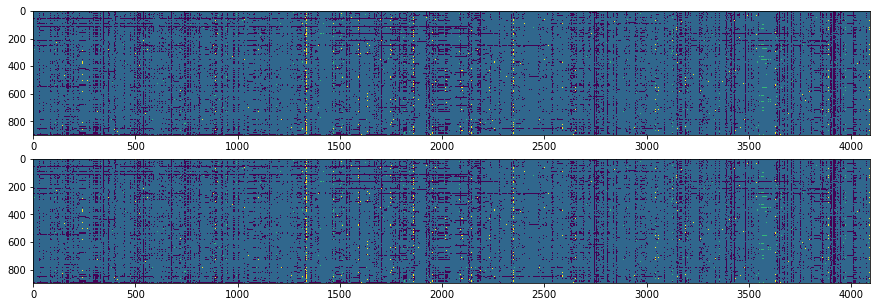

In [159]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
d = ygen[list(ihart_dad_indices), :][:, is_p1].A
plt.imshow(d, aspect='auto', vmin=-1)

plt.subplot(2, 1, 2)
d = ygen[list(ihart_dad_indices), :][:, is_p2].A
plt.imshow(d, aspect='auto', vmin=-1)

plt.show()

In [102]:
print(np.unique(ygen[list(ihart_dad_indices)[5], :].A, return_counts=True))
print(np.unique(ygen[list(ihart_mom_indices)[5], :].A, return_counts=True))

(array([-2, -1,  0,  1,  2], dtype=int8), array([  4205,   4072, 229015,  15204,   2028]))
(array([-2, -1,  0,  1,  2], dtype=int8), array([170612,  12185,  57128,   7283,   7316]))


In [39]:
dp = np.load('%s/chr.Y.dp.npy' % data_dir)
print(dp.shape)

(4610, 254524)


In [103]:
af = np.load('../../SBSE/depth/Y.npy')
print(af.shape)

(4610, 231076, 2)


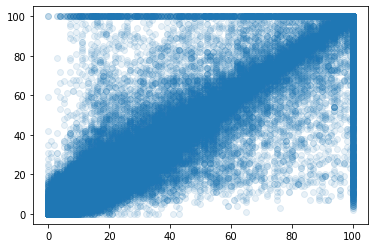

In [139]:
plt.scatter(np.clip(dp[dad_index, coordinates[:, 2]==1], None, 100), 
            np.clip(np.sum(af[dad_index, :, :], axis=1)[:-1], None, 100), alpha=0.1)
plt.show()

In [140]:
dad_index = list(ihart_dad_indices)[3]
a = ygen[dad_index, coordinates[:, 2]==1].A.flatten()
print(np.unique(a, return_counts=True))

(array([-2, -1,  0,  1,  2], dtype=int8), array([  3059,   3897, 208251,  14135,   1733]))


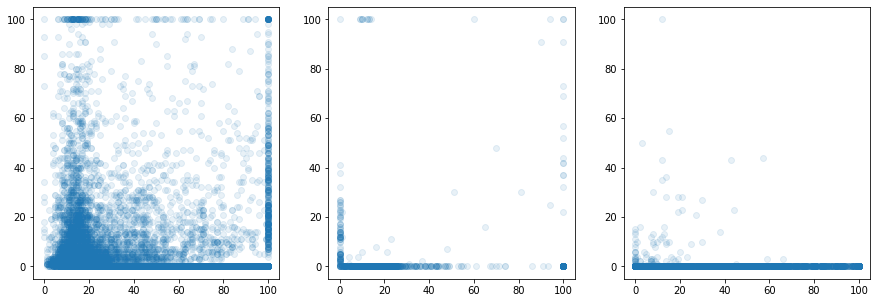

In [142]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
x = af[dad_index, np.where(a==1)[0], :]
plt.scatter(np.clip(x[:, 0], None, 100), 
            np.clip(x[:, 1], None, 100), alpha=0.1)

plt.subplot(1, 3, 2)
x = af[dad_index, np.where(a==2)[0], :]
plt.scatter(np.clip(x[:, 0], None, 100), 
            np.clip(x[:, 1], None, 100), alpha=0.1)

plt.subplot(1, 3, 3)
x = af[dad_index, np.where(a<0)[0], :]
plt.scatter(np.clip(x[:, 0], None, 100), 
            np.clip(x[:, 1], None, 100), alpha=0.1)
plt.show()

In [40]:
#https://genome-cshlp-org.stanford.idm.oclc.org/content/suppl/2016/02/04/gr.199448.115.DC1/Supplemental_Notes_Figures.pdf

is_in_palindrome = np.zeros((coordinates.shape[0],), dtype=bool)
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 25505214) & (coordinates[:, 1] <= 28457697))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 25208036) & (coordinates[:, 1] <= 25504960))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 24071101) & (coordinates[:, 1] <= 24807600))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 20612177) & (coordinates[:, 1] <= 21031990))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 19567757) & (coordinates[:, 1] <= 20612012))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 18271470) & (coordinates[:, 1] <= 18537637))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 17986786) & (coordinates[:, 1] <= 18016774))
is_in_palindrome = is_in_palindrome | ((coordinates[:, 1] >= 16096378) & (coordinates[:, 1] <= 16170110))

print(np.sum(is_in_palindrome))

9134


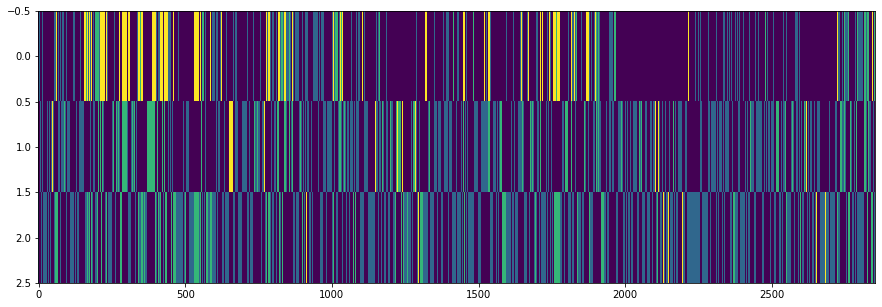

In [21]:
plt.figure(figsize=(15, 5))
d = ygen[ihart_trio_indices[0], :].A
plt.imshow(d[:, ((~d[1, :]==0) | (~d[2, :]==0)) & (np.any(d>=0, axis=0))], aspect='auto', vmin=-1)
plt.show()

In [41]:
vs, cs = np.unique(np.clip(d, -1, None), axis=1, return_counts=True)
print(np.hstack((vs.T, cs[:, np.newaxis])))


[[    -1     -1     -1  17936]
 [    -1     -1      0   1742]
 [    -1     -1      1    118]
 [    -1     -1      2     54]
 [    -1      0     -1   2275]
 [    -1      0      0 152278]
 [    -1      0      1    936]
 [    -1      0      2      8]
 [    -1      1     -1    185]
 [    -1      1      0   1117]
 [    -1      1      1   1837]
 [    -1      1      2     49]
 [    -1      2     -1     75]
 [    -1      2      0     21]
 [    -1      2      1     37]
 [    -1      2      2   1667]
 [     0     -1     -1    217]
 [     0     -1      0    233]
 [     0     -1      1     16]
 [     0     -1      2      1]
 [     0      0     -1    200]
 [     0      0      0  55046]
 [     0      0      1    772]
 [     0      1     -1      8]
 [     0      1      0   1049]
 [     0      1      1    662]
 [     0      1      2      2]
 [     0      2      1      2]
 [     0      2      2     39]
 [     1     -1     -1     29]
 [     1     -1      0     24]
 [     1     -1      1     32]
 [     1

In [64]:
trios_of_interest = []
has_autism = []
for trio_indices in ihart_trio_indices:
    if trio_indices[2] in ihart_son_indices:
        trios_of_interest.append(trio_indices)
        has_autism.append(trio_indices[2] in ihart_autism_indices)
print(len(trios_of_interest))
has_autism = np.array(has_autism)

1646


In [43]:
combos = list(product([0, 1, 2, -1], repeat=2))
combo_to_index = dict([(x, i) for i, x in enumerate(combos)])
print(combo_to_index)


{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, -1): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, -1): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, -1): 11, (-1, 0): 12, (-1, 1): 13, (-1, 2): 14, (-1, -1): 15}


In [46]:
combo_counts = np.zeros((len(trios_of_interest), len(combos)))
counts = np.zeros((len(trios_of_interest), 4))

for i, trio_indices in enumerate(trios_of_interest):
    d = np.clip(ygen[trio_indices, :].A, -1, None)
    vs, cs = np.unique(d[1:, d[0, :]==-1], axis=1, return_counts=True)
    
    for v, c in zip(vs.T, cs):
        combo_counts[i, combo_to_index[tuple(v)]] = c


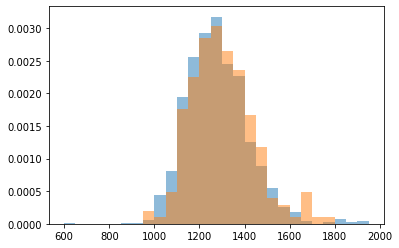

In [87]:
plt.hist(combo_counts[has_autism, combo_to_index[(1, 0)]], 
         alpha=0.5, bins=np.arange(600, 2000, 50), density=True)
plt.hist(combo_counts[~has_autism, combo_to_index[(1, 0)]], 
         alpha=0.5, bins=np.arange(600, 2000, 50), density=True)
plt.show()

0 0 nan 0.12602744469020338 167166.5 167674.5
0 1 6.387596774613855e-114 0.6726161848599426 1170.5 1169.5
0 2 0.151122714425835 0.4304830059013477 14.0 14.0
0 -1 0.6905133890771211 0.6047199092592423 1802.5 1806.0
1 0 6.387596774613855e-114 0.021283490870624883 1268.0 1286.0
1 1 nan 0.6232263822141764 2056.0 2058.0
1 2 0.2261135482598134 0.5403533306136503 36.0 36.0
1 -1 4.334196256492508e-06 0.73298551603563 154.0 153.5
2 0 0.151122714425835 0.5096020943052166 13.0 13.0
2 1 0.2261135482598134 0.141969803368481 36.0 35.0
2 2 nan 0.20000859002822444 1006.0 539.5
2 -1 0.33280651270740236 0.11696301079714859 49.0 48.5
-1 0 0.6905133890771211 0.8735535452571013 1824.0 1796.0
-1 1 4.334196256492508e-06 0.2295792056632273 148.0 154.0
-1 2 0.33280651270740236 0.6196962670575172 51.0 51.0
-1 -1 nan 0.04148418797143705 5495.0 5119.0


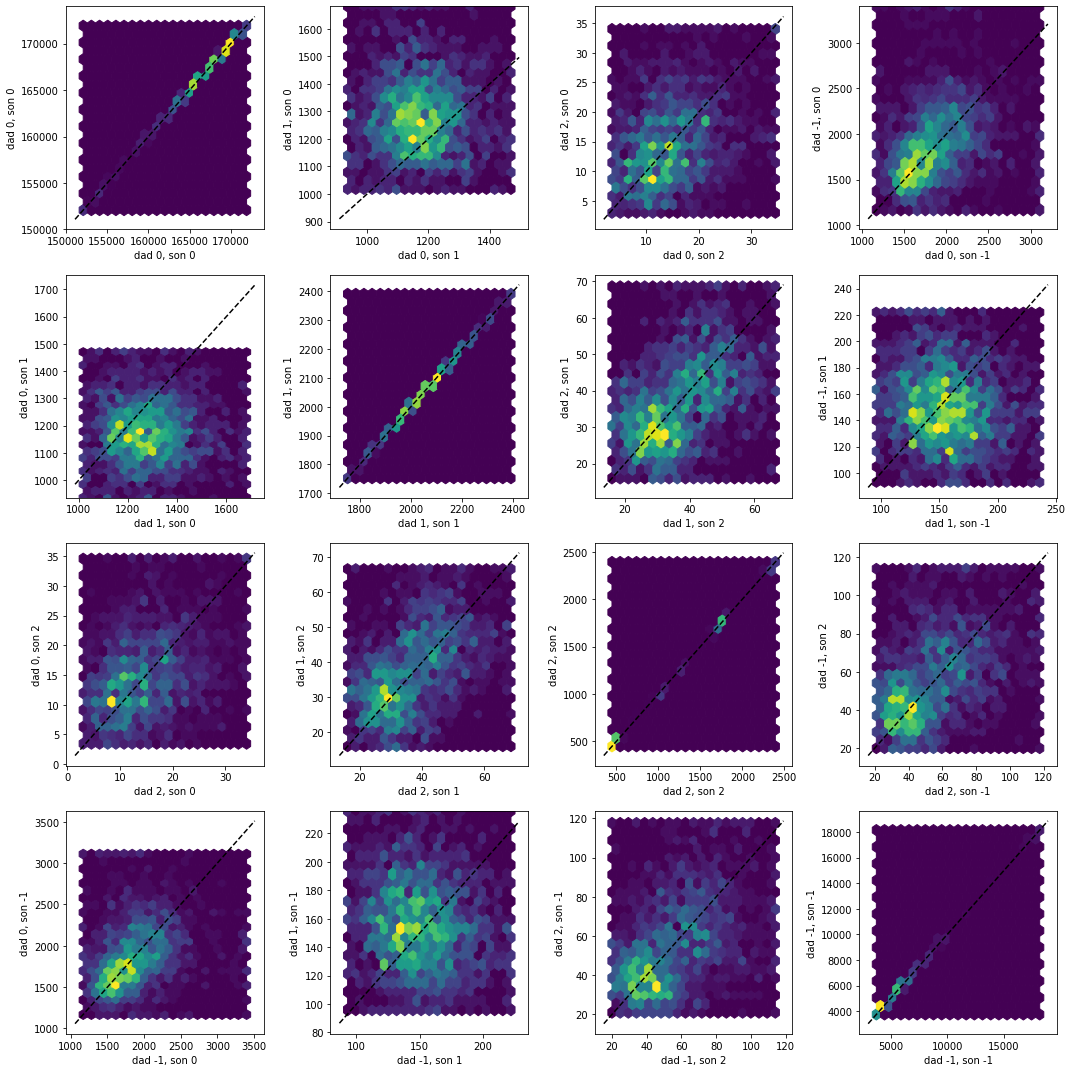

In [82]:
plt.figure(figsize=(15, 15))

for i, (a, b) in enumerate(combos):
    plt.subplot(4, 4, i+1)
    print(a, b, scipy.stats.ttest_rel(combo_counts[:, combo_to_index[(a, b)]],
                                     combo_counts[:, combo_to_index[(b, a)]])[1],
         scipy.stats.ttest_ind(combo_counts[has_autism, combo_to_index[(a, b)]],
                                     combo_counts[~has_autism, combo_to_index[(a, b)]])[1], 
          np.median(combo_counts[has_autism, combo_to_index[(a, b)]]),
          np.median(combo_counts[~has_autism, combo_to_index[(a, b)]]))
    clip_x_low, clip_x_high = np.quantile(combo_counts[:, combo_to_index[(a, b)]], [0.01, 0.99])
    clip_y_low, clip_y_high = np.quantile(combo_counts[:, combo_to_index[(b, a)]], [0.01, 0.99])
    plt.hexbin(np.clip(combo_counts[:, combo_to_index[(a, b)]], clip_x_low, clip_x_high),
               np.clip(combo_counts[:, combo_to_index[(b, a)]], clip_y_low, clip_y_high), gridsize=20)
    
    plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
    plt.xlabel('dad %s, son %s' % (a, b))
    plt.ylabel('dad %s, son %s' % (b, a))

plt.tight_layout()
plt.show()

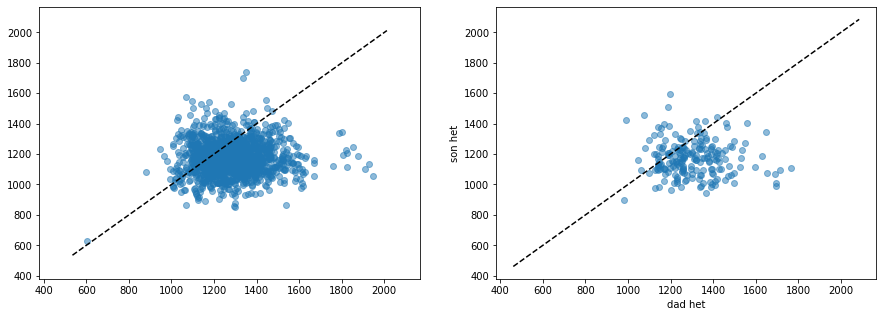

In [89]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.scatter(combo_counts[np.array(has_autism), combo_to_index[(1, 0)]],
            combo_counts[np.array(has_autism), combo_to_index[(0, 1)]], alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(combo_counts[~np.array(has_autism), combo_to_index[(1, 0)]],
            combo_counts[~np.array(has_autism), combo_to_index[(0, 1)]], alpha=0.5)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
#plt.xlim([2500, None])
#plt.ylim([2500, None])
plt.xlabel('dad het')
plt.ylabel('son het')

plt.show()

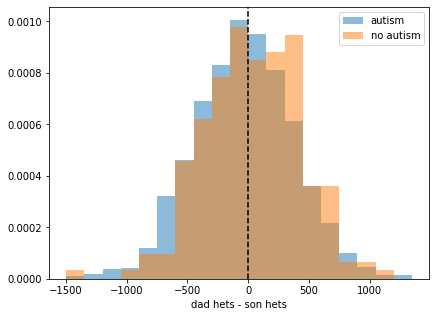

In [167]:
plt.figure(figsize=(15, 5))

bins=np.arange(-1500, 1500, 150)

ax = plt.subplot(1, 2, 1)
plt.hist(combo_counts_p[np.array(has_autism), combo_to_index[(1, 0)]]-\
            combo_counts_p[np.array(has_autism), combo_to_index[(0, 1)]], 
         alpha=0.5, density=True, bins=bins, label='autism')

plt.hist(combo_counts_p[~np.array(has_autism), combo_to_index[(1, 0)]]-\
            combo_counts_p[~np.array(has_autism), combo_to_index[(0, 1)]], 
         alpha=0.5, density=True, bins=bins, label='no autism')
plt.axvline(0, color='black', linestyle='--')
#plt.plot([2500, 5000], [2500, 5000], color='black', linestyle='--')
#plt.xlim([2500, None])
#plt.ylim([2500, None])
plt.xlabel('dad hets - son hets')
plt.legend()

plt.show()

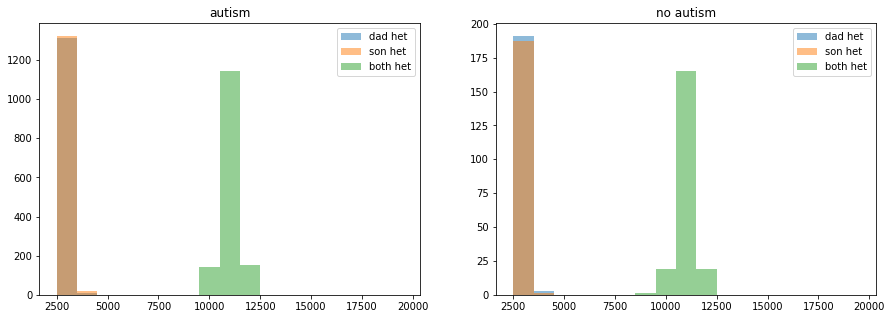

In [171]:
plt.figure(figsize=(15, 5))

bins = np.arange(2500, 20000, 1000)
#bins = np.arange(0, 100, 5)
plt.subplot(1, 2, 1)
plt.hist(combo_counts_p[np.array(has_autism), combo_to_index[(1, 0)]], alpha=0.5, bins=bins, label='dad het')
plt.hist(combo_counts_p[np.array(has_autism), combo_to_index[(0, 1)]], alpha=0.5, bins=bins, label='son het')
plt.hist(combo_counts_p[np.array(has_autism), combo_to_index[(1, 1)]], alpha=0.5, bins=bins, label='both het')
plt.title('autism')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(combo_counts_p[~np.array(has_autism), combo_to_index[(1, 0)]], alpha=0.5, bins=bins, label='dad het')
plt.hist(combo_counts_p[~np.array(has_autism), combo_to_index[(0, 1)]], alpha=0.5, bins=bins, label='son het')
plt.hist(combo_counts_p[~np.array(has_autism), combo_to_index[(1, 1)]], alpha=0.5, bins=bins, label='both het')
plt.title('no autism')
plt.legend()

#plt.scatter(combo_counts[~np.array(has_autism), combo_to_index[(1, 0)]],
##            combo_counts[~np.array(has_autism), combo_to_index[(0, 1)]], alpha=0.5)
#plt.xlim([2500, None])
#plt.ylim([2500, None])
#plt.xlabel('dad het')
#plt.ylabel('son het')

plt.show()

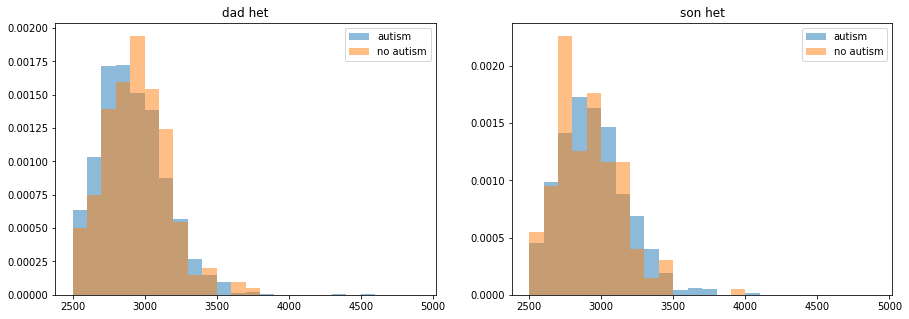

In [151]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(combo_counts_p[np.array(has_autism), combo_to_index[(1, 0)]]+combo_counts_p[np.array(has_autism), combo_to_index[(1, 2)]], 
         density=True, alpha=0.5, bins=bins, label='autism')
plt.hist(combo_counts_p[~np.array(has_autism), combo_to_index[(1, 0)]]+combo_counts_p[~np.array(has_autism), combo_to_index[(1, 2)]], 
         density=True, alpha=0.5, bins=bins, label='no autism')
plt.title('dad het')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(combo_counts_p[np.array(has_autism), combo_to_index[(0, 1)]]+combo_counts_p[np.array(has_autism), combo_to_index[(2, 1)]], 
         density=True, alpha=0.5, bins=bins, label='autism')
plt.hist(combo_counts_p[~np.array(has_autism), combo_to_index[(0, 1)]]+combo_counts_p[~np.array(has_autism), combo_to_index[(2, 1)]], 
         density=True, alpha=0.5, bins=bins, label='no autism')
plt.title('son het')
plt.legend()
#plt.scatter(combo_counts[~np.array(has_autism), combo_to_index[(1, 0)]],
##            combo_counts[~np.array(has_autism), combo_to_index[(0, 1)]], alpha=0.5)
#plt.xlim([2500, None])
#plt.ylim([2500, None])
#plt.xlabel('dad het')
#plt.ylabel('son het')

plt.show()

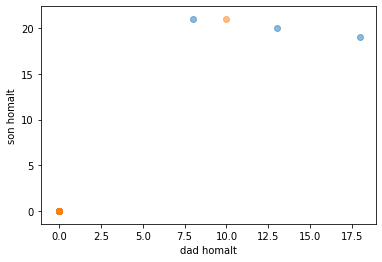

In [152]:
plt.scatter(combo_counts[np.array(has_autism), combo_to_index[(0, 2)]],
            combo_counts[np.array(has_autism), combo_to_index[(2, 0)]], alpha=0.5)
plt.scatter(combo_counts[~np.array(has_autism), combo_to_index[(0, 2)]],
            combo_counts[~np.array(has_autism), combo_to_index[(2, 0)]], alpha=0.5)
#plt.xlim([0, 50])
#plt.ylim([0, 50])
plt.xlabel('dad homalt')
plt.ylabel('son homalt')

plt.show()